# Семинар 6: временные ряды I

## Вступление
Сегодня мы познакомимся с анализом временных рядов при помощи библиотеки [ETNA](https://etna.tinkoff.ru/). Перед установкой ноутбука убедитесь, что у вас установлен Python 3.9: ноутбук был прогнан на версии 3.9.16, на более старших версиях может ломаться.

BTW, у библиотеки есть группа в тг на предмет вопросов, в том числе по проведенной коллегами лекции: https://t.me/etna_support

### План семинара <a class="anchor" id="menu"></a>
* [Беглое знакомство](#chapter1)
* [Валидация](#chapter2)
* [Разведывательный анализ данных](#chapter3)
* [Выбросы](#chapter4)
* [Регрессоры и внешние данные](#chapter5)
* [Ансамбли (опционально)](#chapter6)
* [Стратегии прогнозирования](#chapter7)

In [ ]:
# !pip install -r requirements.txt

In [ ]:
import warnings
import gdown
import os
import zipfile

import matplotlib.pyplot as plt
import pandas as pd
from etna.analysis import cross_corr_plot
from etna.analysis import distribution_plot
from etna.analysis import plot_anomalies
from etna.analysis import plot_anomalies_interactive
from etna.analysis import plot_backtest
from etna.analysis import plot_correlation_matrix
from etna.analysis import plot_forecast
from etna.analysis import acf_plot
from etna.analysis.outliers import get_anomalies_density
from etna.analysis.outliers import get_anomalies_hist
from etna.analysis.outliers import get_anomalies_median
from etna.analysis.outliers import get_anomalies_prediction_interval
from etna.datasets import TSDataset
from etna.ensembles import DirectEnsemble, StackingEnsemble, VotingEnsemble
from etna.metrics import MAE, MAPE, MSE, SMAPE
from etna.models import CatBoostPerSegmentModel
from etna.models import CatBoostMultiSegmentModel
from etna.models import LinearPerSegmentModel
from etna.models import MovingAverageModel
from etna.models import NaiveModel
from etna.models import AutoARIMAModel
from etna.models import ProphetModel
from etna.models import SeasonalMovingAverageModel
from etna.pipeline import AutoRegressivePipeline, Pipeline, assemble_pipelines
from etna.transforms import DateFlagsTransform
from etna.transforms import FilterFeaturesTransform
from etna.transforms import HolidayTransform
from etna.transforms import LagTransform
from etna.transforms import LinearTrendTransform
from etna.transforms import LogTransform
from etna.transforms import MeanTransform
from etna.transforms import MedianOutliersTransform
from etna.transforms import SegmentEncoderTransform
from etna.transforms import TimeSeriesImputerTransform
from etna.datasets import load_dataset

warnings.filterwarnings("ignore")

Скачаем необходимые данные

In [ ]:
url = "https://drive.google.com/file/d/1vyr7Fj7iZyrlcY4vXuCY2gfuDEajMXrq/view?usp=share_link"
output = "data.zip"
gdown.download(url=url, output=output, quiet=False, fuzzy=True)

with zipfile.ZipFile("data.zip", "r") as zip_ref:
    zip_ref.extractall("./")

os.remove("data.zip")

Downloading...
From: https://drive.google.com/uc?id=1vyr7Fj7iZyrlcY4vXuCY2gfuDEajMXrq
To: /Users/d.p.sablin/PycharmProjects/experiments/experiments/iad-applied-seminars/data.zip
100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1.71M/1.71M [00:00<00:00, 6.39MB/s]


## 1. Беглое знакомство <a class="anchor" id="chapter1"></a>
[Назад к меню](#menu)

### 1.1. TSDataset и его основные методы

По ходу семинара мы будем использовать несколько датасетов
- модельный
- продажи вина в Австралии
- данные с относительно недавнего соренования Kaggle по предсказанию продаж мерча
- данные о погоде в Скандинавии.


Загрузим их сразу, и будем обращаться к каждому по необходимости

In [ ]:
folder = "data"
toy_synthetic = pd.read_csv(f"{folder}/example_dataset.csv")
australian_wine = pd.read_csv(f"{folder}/monthly-australian-wine-sales.csv")
kaggle_merch = pd.read_csv(f"{folder}/nordic_merch_sales.csv")
nordics_weather = pd.read_csv(f"{folder}/nordics_weather.csv")

Удобной фичей является наличие встроенных датасетов для работы с данными. Представляется целый [список](https://docs.etna.ai/stable/internal_datasets.html). Загрузим данные о продажи вина в Австралии

In [ ]:
australian_wine_tsdataset = load_dataset(name="australian_wine_sales_monthly", parts="full")

Для этой секции будем использовать продажи вина в Австралии

In [ ]:
original_df = australian_wine.copy(deep=True)
original_df.head()

month  sales
0  1980-01-01  15136
1  1980-02-01  16733
2  1980-03-01  20016
3  1980-04-01  17708
4  1980-05-01  18019

В ETNA реализован специальный класс данных <b>TSDataset</b>, которым мы будем активно пользоваться. Его преимущества:
* проводит валидацию данных
* взаимодействует с другими частями пайплайна прогнозирования
* помогает проводить базовую аналитику данных
* генерирует будущие значения ряда для прогнозирования
* удобно индексироваться по рядам: первый индекс отвечает за временное измерение, второй - за сегмент, третий - за отдельный столбец

<br></br>
Для работы необходимо преобразовать `df` в один из возможных форматов:
- <b>Long</b> (длинный): все ряды располагаются в одних и тех же колонках
  - Колонка `timestamp` для хранения временных меток;
  - Колонка `segment` для хранения идентификатора ряда;
  - Колонки таргета (`target`) и фичей.
- <b>Wide</b> (широкий): разные ряды располагаются в разных колонках
  - Индекс для хранения временных меток;
  - Двухуровневые колонки вида (segment, feature).

Подготовим данные в long формате. Для этого переименуем колонки и введем `segment="main"`, т.к. у нас всего один ряд и можем назвать его как угодно.

In [ ]:
original_df["timestamp"] = pd.to_datetime(original_df["month"])
original_df["target"] = original_df["sales"]
original_df.drop(columns=["month", "sales"], inplace=True)
original_df["segment"] = "main"
original_df.head()

timestamp  target segment
0 1980-01-01   15136    main
1 1980-02-01   16733    main
2 1980-03-01   20016    main
3 1980-04-01   17708    main
4 1980-05-01   18019    main

Для работы необходимо создать объект класса `TSDataset` и передать исходный датафрейм, дополнительно указав частоту данных в правильном формате. В нашем случае будет выставлена частота "MS", т.к. работаем с месячными данными. Узнать подходящее обозначение частоты можно по [таблице](https://pandas.pydata.org/docs/user_guide/timeseries.html#dateoffset-objects).

In [ ]:
ts = TSDataset(original_df, freq="MS")

Посмотрим на доступные нам методы:

Вот так можно посмотреть основную информацию о наборе данных:

In [ ]:
ts.info()

<class 'etna.datasets.TSDataset'>
num_segments: 1
num_exogs: 0
num_regressors: 0
num_known_future: 0
freq: MS
         start_timestamp end_timestamp  length  num_missing
segments                                                   
main          1980-01-01    1994-08-01     176            0


Или в формате `DataFrame`

In [ ]:
ts.describe()

start_timestamp end_timestamp  length  num_missing  num_segments  \
segments                                                                    
main          1980-01-01    1994-08-01     176            0             1   

          num_exogs  num_regressors  num_known_future freq  
segments                                                    
main              0               0                 0   MS

А вот так можно отрисовать датасет

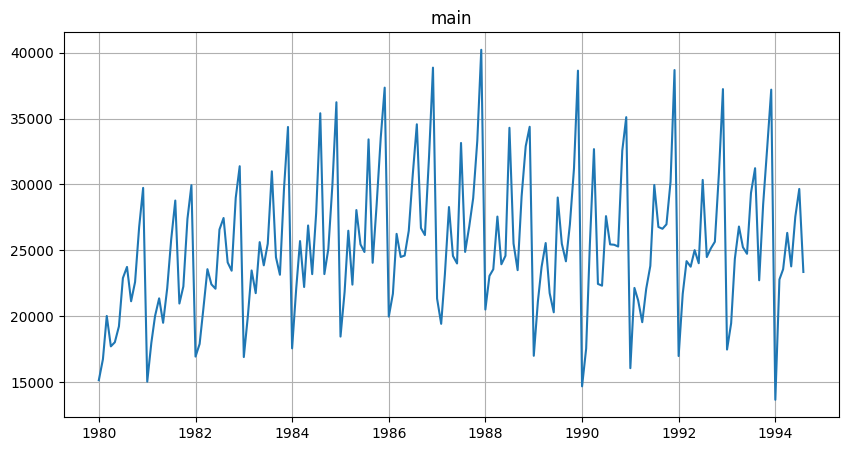

In [ ]:
ts.plot()

### 1.2. Прогнозируем временной ряд

В библиотеке реализовано множество различных моделей, разберем на некоторые из них:

#### 1.2.1. Naive model

> Лаги — это некоторое предыдущее значение временного ряда.

Например, первый лаг — это вчерашнее значение. А пятый лаг — значение пять дней назад. Такие признаки необходимы для регрессионных моделей, например линейной регрессии или бустинга, чтобы получить информацию о прошлом ряда.[1]

[1] *Андрей Алексеев, "Как прогнозировать временные ряды с ETNA"*

Naive model - Модель временного ряда, в которой его текущее значение равно некоторому лагу.

In [ ]:
HORIZON = 8

In [ ]:
train_ts, test_ts = ts.train_test_split(test_size=HORIZON)

Обучаем модель:

In [ ]:
model = NaiveModel(lag=12)

Удобным интрументом работы обучения и запуска являются пайпланы. В библиотеке представлен класс для работы о важности использованивания пайплайнов можно почитать [тут](https://medium.com/analytics-vidhya/what-is-a-pipeline-in-machine-learning-how-to-create-one-bda91d0ceaca), или [тут](https://cloud.google.com/vertex-ai/docs/pipelines/introduction).

Рассмотрим использование [`Pipeline`](https://docs.etna.ai/stable/api_reference/api/etna.pipeline.Pipeline.html#etna.pipeline.Pipeline) для работы с данными, подробнее почитать о всех видах [пайплайнов](https://docs.etna.ai/stable/api_reference/pipeline.html#module-etna.pipeline).

In [ ]:
pipeline = Pipeline(model=model, horizon=HORIZON)
pipeline.fit(train_ts)

Pipeline(model = NaiveModel(lag = 12, ), transforms = (), horizon = 8, )

Делаем прогнозирование на интересуемый горизонт событий используя метод `.backtest`, который возращает предсказание состоящее из следующих компонент:

- `dataframe` метрик
- `dataframe` предсказаний
- `dataframe` информаций о фолдах

In [ ]:
forecast_ts = pipeline.forecast(train_ts)

При оценке моделей, помимо хорошо нам известных MSE и MAE, мы будем прибегать к популярным в контексте временных рядов метрикам, измеряющим ошибку в процентах - MAPE и SMAPE

> MAPE – Mean Absolute Percent Error, средний процент отклонения

$$\text{MAPE}(y, \hat{y}) = \frac{100\%}{N} \sum_{i=1}^{N} \frac{|y_i - \hat{y}_i|}{|y_i|}$$

> SMAPE – Symmetric Mean Absolute Percent Error, симметричный средний процент отклонения

$$\text{SMAPE}(y, \hat{y}) = \frac{100\%}{N} \sum_{i=1}^{N} \frac{|y_i - \hat{y}_i|}{(y_i + \hat{y_i}) / 2}$$

Эти функции ошибок выглядят очень логично: модуль разницы между ответом алгоритма и истинным значением мы делим на их среднее (или истинное значение). Будем считать, что значения целевого признака и ответы алгоритма положительные.

Функции SMAPE и MAPE часто используют при прогнозировании временных рядов, особенно финансовых, где как раз разумно измерять ошибку в процентах. Например, рассмотри две ситуации: вместо цены за акцию 1 руб. мы предсказали 2 руб. и вместо 101 руб. – 102 руб. В первом случае мы ошиблись почти в два
раза, а во втором «почти угадали», тем не менее MAE-ошибка в обоих случаях равна 1, а вот (S)MAPE сильно различается.[2]

[2] *Александр Дьяконов, «Анализ малых данных»*

Итак, встроенными в ETNA методами посчитаем `SMAPE` и визуализируем прогноз:

In [ ]:
smape = SMAPE()
print(f"{smape(y_true=test_ts, y_pred=forecast_ts)['main']:.2f}")

11.49


Нарисуем график прогноза (учитывайте разницу в масштабе с исходным графиком, и не удивляйтесь разрыву - он обусловлен сезонностью и "водоразделом" между `train` и `test`/`forecast`)

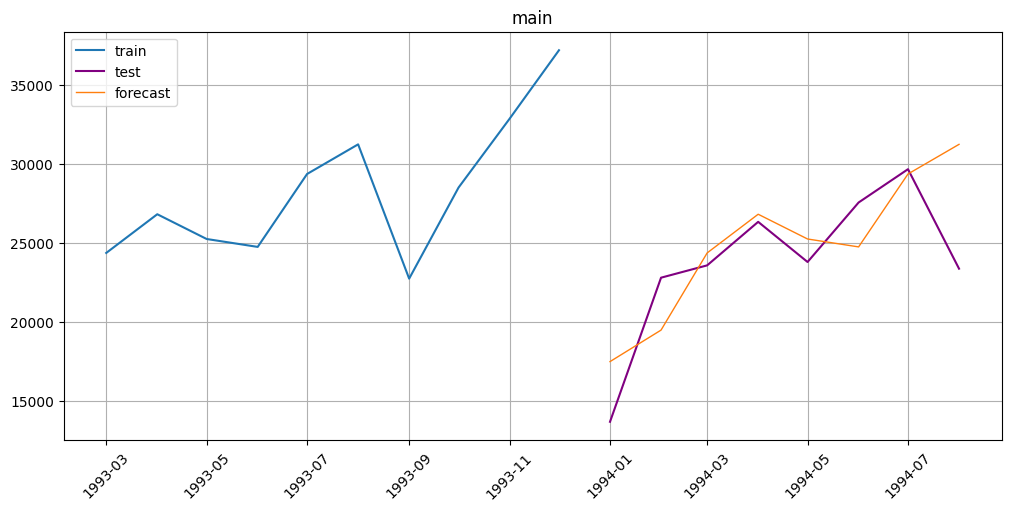

In [ ]:
plot_forecast(forecast_ts, test_ts, train_ts, n_train_samples=10)

### 1.2.2. Prophet

Попробуем улучшить результат при помощи модели Prophet

> Prophet - это хорошо зарекомендовавшая себя аддитивная нелинейная регрессионная модель, состоящая из следующих компонент:

$$y_t= g(t)+ s(t)+ h(t)+ \epsilon_t$$

А теперь более подробно про каждую из компонент:
* Тренд $g(t)$ — это кусочно-линейная или логистическая функция. С линейной функцией все понятно. Логистическая же функция вида $g(t) = \frac{C}{1+exp(-k(t-b))}$ позволяет моделировать рост с насыщением, когда при увеличении показателя снижается темп его роста. Типичный пример — это рост аудитории приложения или сайта.
* Сезонные компоненты $s(t)$ отвечают за моделирование периодических изменений, связанных с недельной и годовой сезонностью. Недельная сезонность моделируется с помощью dummy variables. Добавляются 6 дополнительных признаков, например, [monday, tuesday, wednesday, thursday, friday, saturday], которые принимают значения 0 и 1 в зависимости от даты. Признак sunday, соответствующий седьмому дню недели, не добавляют, потому что он будут линейно зависеть от других дней недели и это будет влиять на модель (dummy trap). Годовая же сезонность моделируется рядами Фурье.
* Компонента $h(t)$ отвечает за заданные пользователем аномальные дни, в том числе и нерегулярные, такие как, например, Black Fridays.
* Ошибка $\epsilon_{t}$ содержит информацию, которая не учтена моделью (белый шум) [3]

[3] Мария Мансурова, "Предсказываем будущее с помощью библиотеки Facebook Prophet"

Также библиотека дает возможность предсказывать на определенный горизонт, за счет использования метода `.forecast`

In [ ]:
model = ProphetModel()

pipeline = Pipeline(model=model, horizon=HORIZON)
pipeline.fit(train_ts)

forecast_ts = pipeline.forecast(train_ts)

print(f"{smape(y_true=test_ts, y_pred=forecast_ts)['main']:.2f}")

10:32:50 - cmdstanpy - INFO - Chain [1] start processing
10:32:50 - cmdstanpy - INFO - Chain [1] done processing


10.50


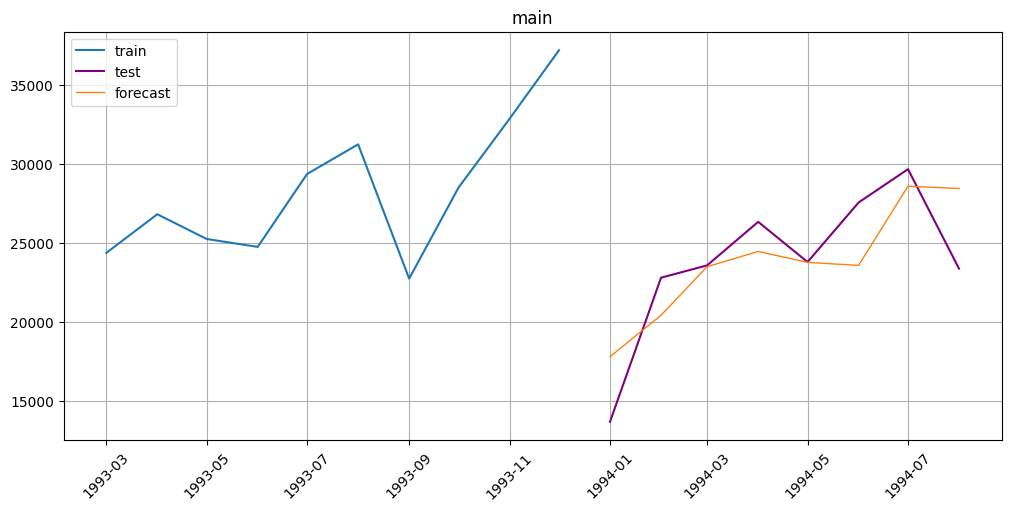

In [ ]:
plot_forecast(forecast_ts, test_ts, train_ts, n_train_samples=10)

#### 1.2.3. Catboost
На примере Catboost посмотрим, как можно сгенерировать лаги в качестве дополнительных признаков при помощи преобразований (transforms):

> Catboost - алгоритм построения моделей машинного обучения, использующий схему градиентного бустинга.

Градиентный бустинг — метод машинного обучения, который создает решающую модель прогнозирования в виде ансамбля слабых моделей прогнозирования, обычно деревьев решений. Он строит модель поэтапно, позволяя оптимизировать произвольную дифференцируемую функцию потерь.

Идея бустинг-подхода заключается в комбинации слабых (с невысокой обобщающей способностью) функций, которые строятся в ходе итеративного процесса, где на каждом шаге новая модель обучается с использованием данных об ошибках предыдущих. Результирующая функция представляет собой линейную комбинацию базовых, слабых моделей.

Также библиотека дает возможность работать с данной технологией, для чего существует `CatBoostMultiSegmentModel` и `CatBoostPerSegmentModel`. Почитать можно [тут](https://docs.etna.ai/stable/api_reference/api/etna.models.CatBoostMultiSegmentModel.html#etna-models-catboostmultisegmentmodel) и [тут](https://docs.etna.ai/stable/api_reference/api/etna.models.CatBoostPerSegmentModel.html).

- `CatBoostMultiSegmentModel` - для всех временных рядов обучается одна модель
- `CatBoostPerSegmentModel` - для каждого временного ряда обучается своя модель

In [ ]:
lags = LagTransform(in_column="target", lags=list(range(8, 24, 1)))
transforms = [lags]

model = CatBoostMultiSegmentModel()

pipeline = Pipeline(model=model, transforms=transforms, horizon=HORIZON)
pipeline.fit(train_ts)

forecast_ts = pipeline.forecast(train_ts)

smape = SMAPE()
print(f"{smape(y_true=test_ts, y_pred=forecast_ts)['main']:.2f}")

10.72


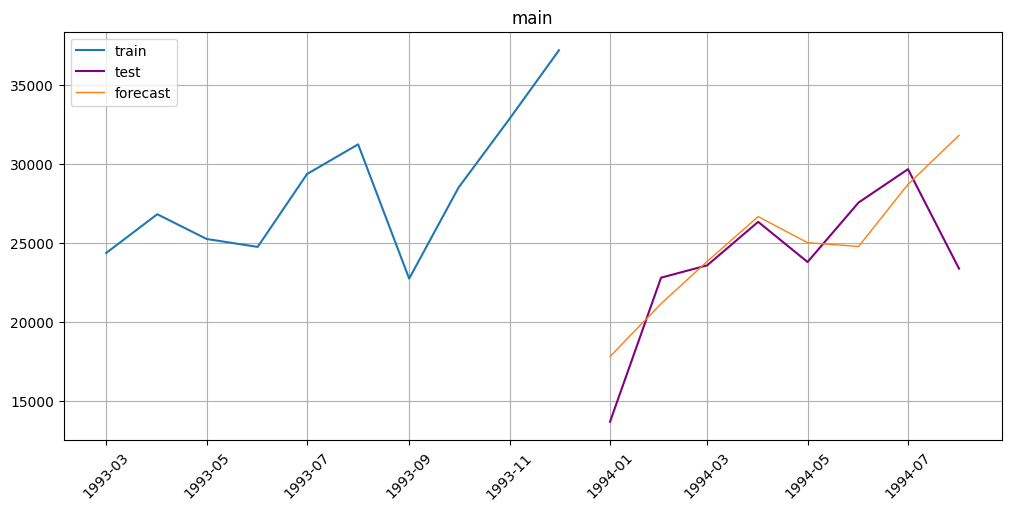

In [ ]:
plot_forecast(forecast_ts, test_ts, train_ts, n_train_samples=10)

### 1.2.4. ARIMA

Знакомая по лекции модель:

> ARIMA (autoregressive integrated moving average) - авторегрессионное интегрированное скользящее среднее  является обобщением модели авторегрессионного скользящего среднего. Обычно модель упоминается, как ARIMA(p,d,q), где p,d и q — целые неотрицательные числа, характеризующие порядок для частей модели (соответственно авторегрессионной, интегрированной и скользящего среднего) [4]

[4] machinelearning.ru

Предлагается реализовать самостоятельно, подробнее можно почитать про [ARIMA](https://docs.etna.ai/latest/api_reference/api/etna.models.AutoARIMAModel.html#etna.models.AutoARIMAModel):

In [ ]:
train_ts, test_ts = ts.train_test_split(test_size=HORIZON)

In [ ]:
train_ts.inverse_transform(transforms)
lags = LagTransform(in_column="target", lags=list(range(8, 34, 1)))

transforms = [lags]

model = AutoARIMAModel()

pipeline = Pipeline(model=model, transforms=transforms, horizon=HORIZON)
pipeline.fit(train_ts)

forecast_ts = pipeline.forecast(train_ts)

smape = SMAPE()
print(f"{smape(y_true=test_ts, y_pred=forecast_ts)['main']:.2f}")

12.56


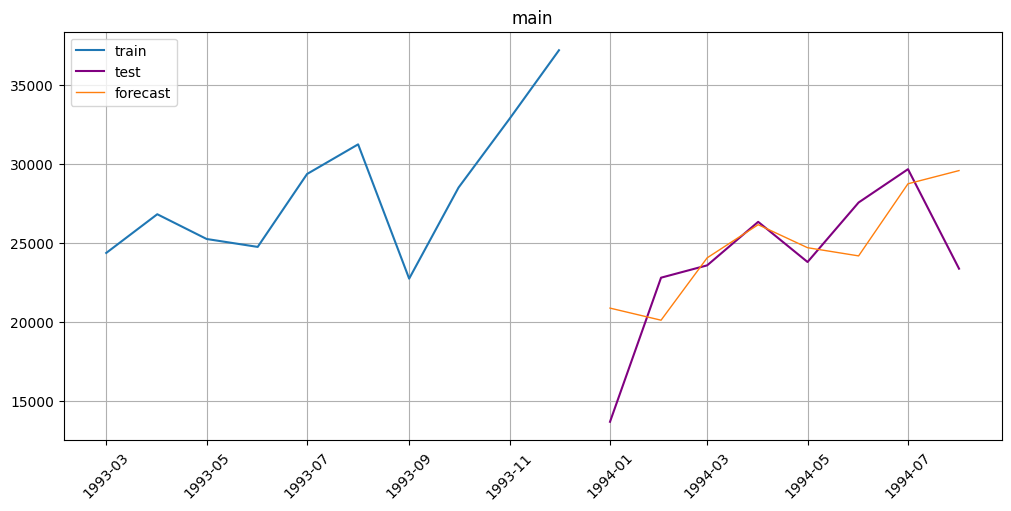

In [ ]:
plot_forecast(forecast_ts, test_ts, train_ts, n_train_samples=10)

### 1.3. Прогнозируем панельные данные

Проделанные выше операции легко обобщаются на случай [панельных данных](https://ru.wikipedia.org/wiki/Панельные_данные), т.е. множества временных рядов по одним и тем же временным меткам. Для этого перейдем к модельному датасету, состоящему из 4-х параллельных рядов

In [ ]:
original_df = toy_synthetic.copy(deep=True)
original_df.head()

timestamp    segment  target
0  2019-01-01  segment_a     170
1  2019-01-02  segment_a     243
2  2019-01-03  segment_a     267
3  2019-01-04  segment_a     287
4  2019-01-05  segment_a     279

In [ ]:
df = TSDataset.to_dataset(original_df)
ts = TSDataset(df, freq="D")
ts.info()

<class 'etna.datasets.TSDataset'>
num_segments: 4
num_exogs: 0
num_regressors: 0
num_known_future: 0
freq: D
          start_timestamp end_timestamp  length  num_missing
segments                                                    
segment_a      2019-01-01    2019-11-30     334            0
segment_b      2019-01-01    2019-11-30     334            0
segment_c      2019-01-01    2019-11-30     334            0
segment_d      2019-01-01    2019-11-30     334            0


In [ ]:
ts.describe()

start_timestamp end_timestamp  length  num_missing  num_segments  \
segments                                                                     
segment_a      2019-01-01    2019-11-30     334            0             4   
segment_b      2019-01-01    2019-11-30     334            0             4   
segment_c      2019-01-01    2019-11-30     334            0             4   
segment_d      2019-01-01    2019-11-30     334            0             4   

           num_exogs  num_regressors  num_known_future freq  
segments                                                     
segment_a          0               0                 0    D  
segment_b          0               0                 0    D  
segment_c          0               0                 0    D  
segment_d          0               0                 0    D

После разведки данных выше, рассмотрим сами временные ряды.
Для автоматической отрисовки в `TSDataset` есть метод `.plot`, который автоматически отрисовывает ряды, подробнее прочитать о допольнительных параметрах можно [тут](https://docs.etna.ai/latest/api_reference/api/etna.datasets.TSDataset.html#etna.datasets.TSDataset.plot)

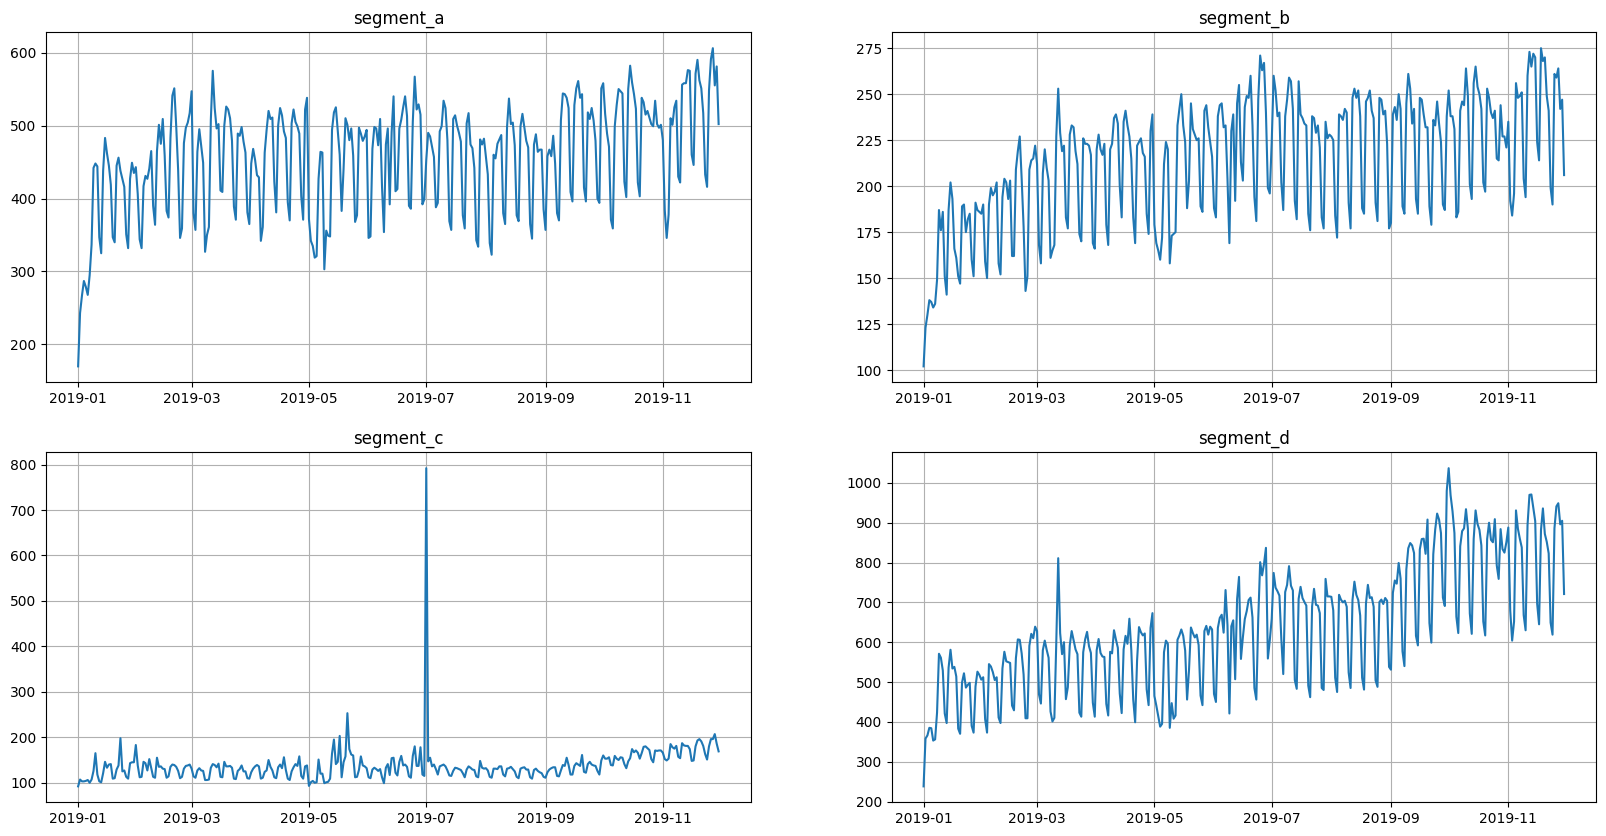

In [ ]:
ts.plot()

Для предсказания нам следуюет преобразовать наш набор данных. Для данных задач подходит такая сущность как `Transform`, которые помогают в преобразовании данных.

В нашей задаче добавим допольнительную информацию для улучшения качества модели, для этого будем использовать следующие
1. `LogTransform` - логарифмирует для данного ряда
2. `LinearTrendTransform` - устраняет тренд с использованием линейной регрессии с полиномиальными характеристиками
3. `SegmentEncoderTransform` - кодирует метку сегмента как категориальную. Создает столбец «segment_code».
4. `LagTransform` - генерирует набор лагов целевой переменной
5. `DateFlagsTransform` - извлекает основные признаки на основе даты
6. `MeanTransform` - рассчитывает среднее для окна


С полным списком ознакамливаемся в [библиотеке](https://docs.etna.ai/latest/api_reference/transforms.html#transforms).

In [ ]:
log = LogTransform(in_column="target")
trend = LinearTrendTransform(in_column="target")
seg = SegmentEncoderTransform()

lags = LagTransform(in_column="target", lags=list(range(30, 96, 1)))
d_flags = DateFlagsTransform(
    day_number_in_week=True,
    day_number_in_month=True,
    week_number_in_month=True,
    week_number_in_year=True,
    month_number_in_year=True,
    year_number=True,
    special_days_in_week=[5, 6],
)
mean30 = MeanTransform(in_column="target", window=30)
transforms = [log, trend, lags, d_flags, seg, mean30]

Используем метод `.train_test_split` для разбивки данных на тестовые и тренировочные.

In [ ]:
HORIZON = 30
train_ts, test_ts = ts.train_test_split(test_size=HORIZON)

In [ ]:
model = CatBoostMultiSegmentModel()

pipeline = Pipeline(model=model, transforms=transforms, horizon=HORIZON)
pipeline.fit(train_ts)

forecast_ts = pipeline.forecast(train_ts)

smape = SMAPE()
smape(y_true=test_ts, y_pred=forecast_ts)

{'segment_a': 5.896891668877801,
 'segment_b': 4.397964779952168,
 'segment_c': 10.435207629641658,
 'segment_d': 5.085585717990846}

Как можем видеть в случае наличия нескольких сегментов, информация о метриках выводится для каждой.

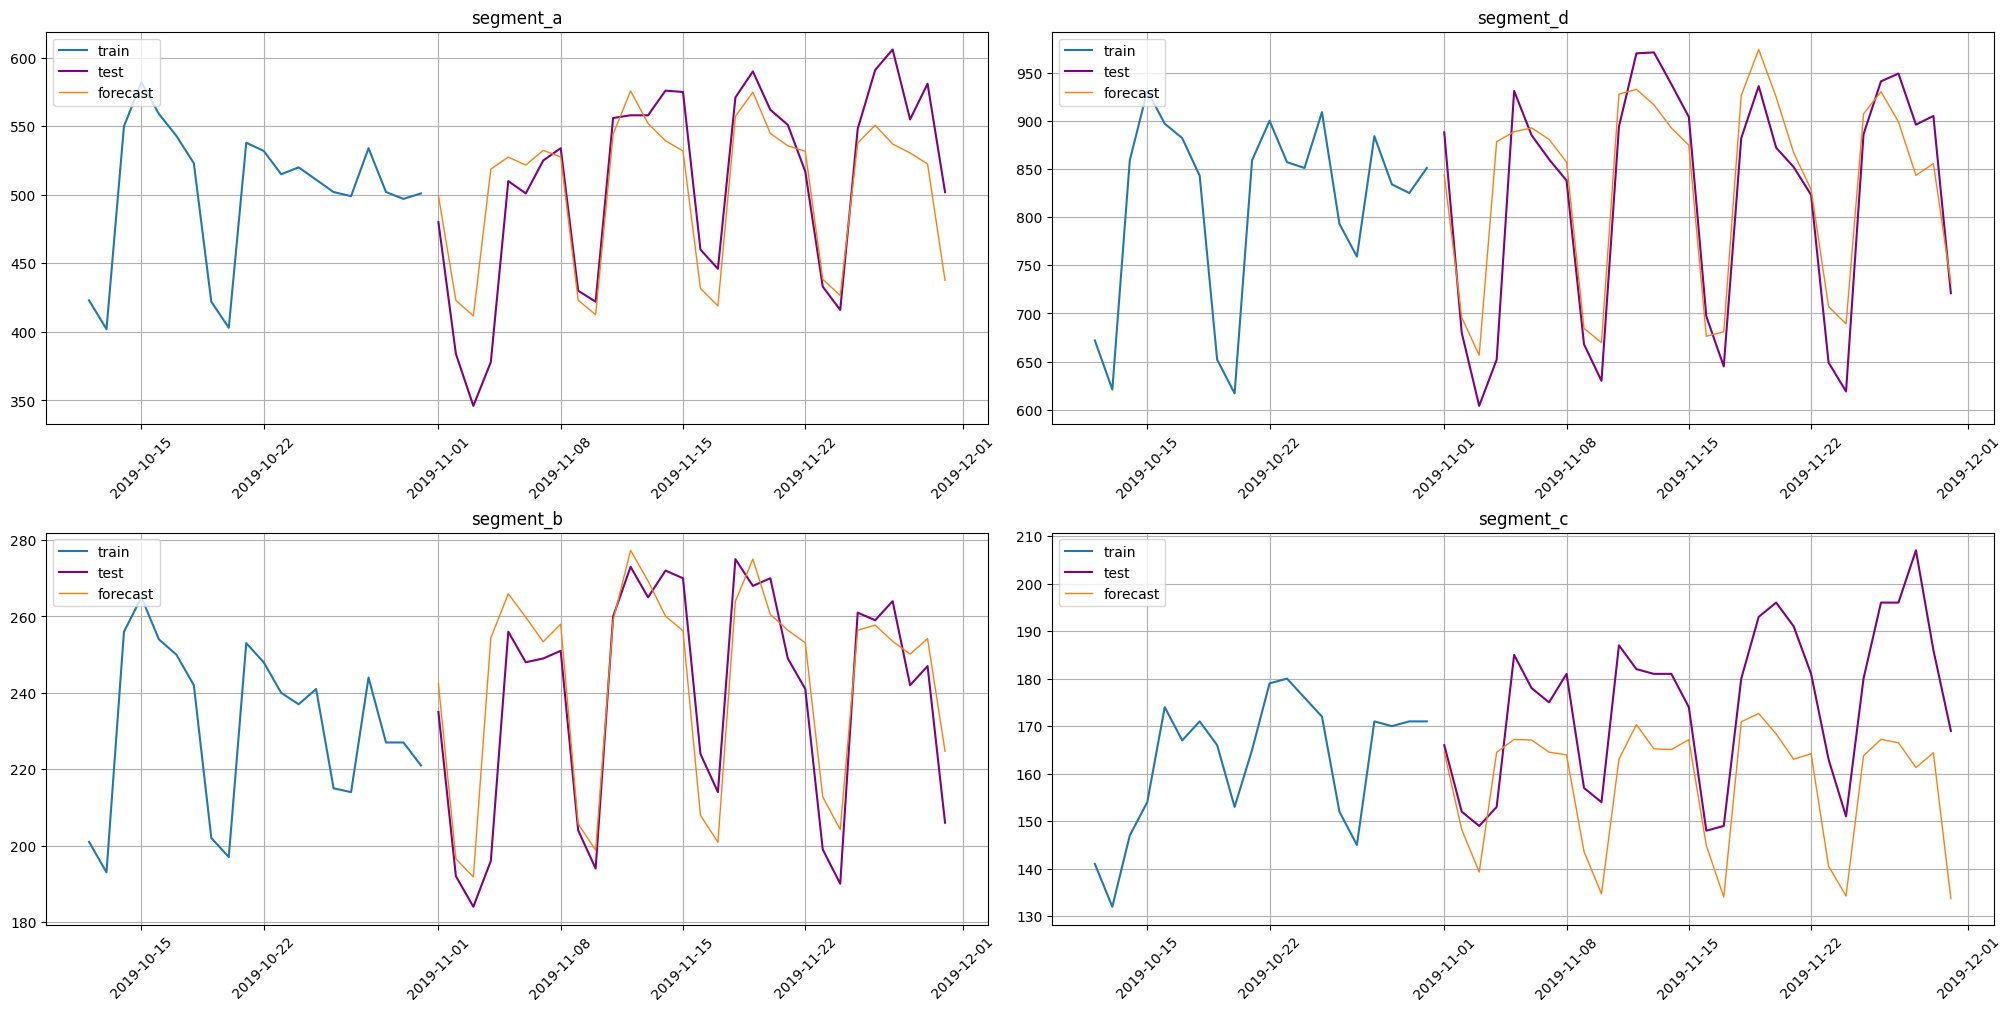

In [ ]:
plot_forecast(forecast_ts, test_ts, train_ts, n_train_samples=20)

## 2. Валидация <a class="anchor" id="chapter2"></a>
[Назад к меню](#menu)

### 2.1. Что такое бектест

Бэктест — это метод оценки работы модели, на основе разбития данных на фолды(промежутки)

<b>Механизм работы</b>

В самой простой версии алгоритм выглядит следующим образом.
- Берем в качестве текущего датасета исходный датасет.
- Повторяем `n_folds` раз.
  - У текущего датасета выделяем тестовую часть, взяв последние `horizon` точек в каждом сегменте. Оставшееся будет тренировочной частью.
  - Обучаемся на тренировочной части и считаем метрики на тестовой.
  - Убираем из текущего датасета последние `horizon` точек в каждом сегменте и получаем новый текущий датасет.

На картинке пример работы с `n_folds = 3`.

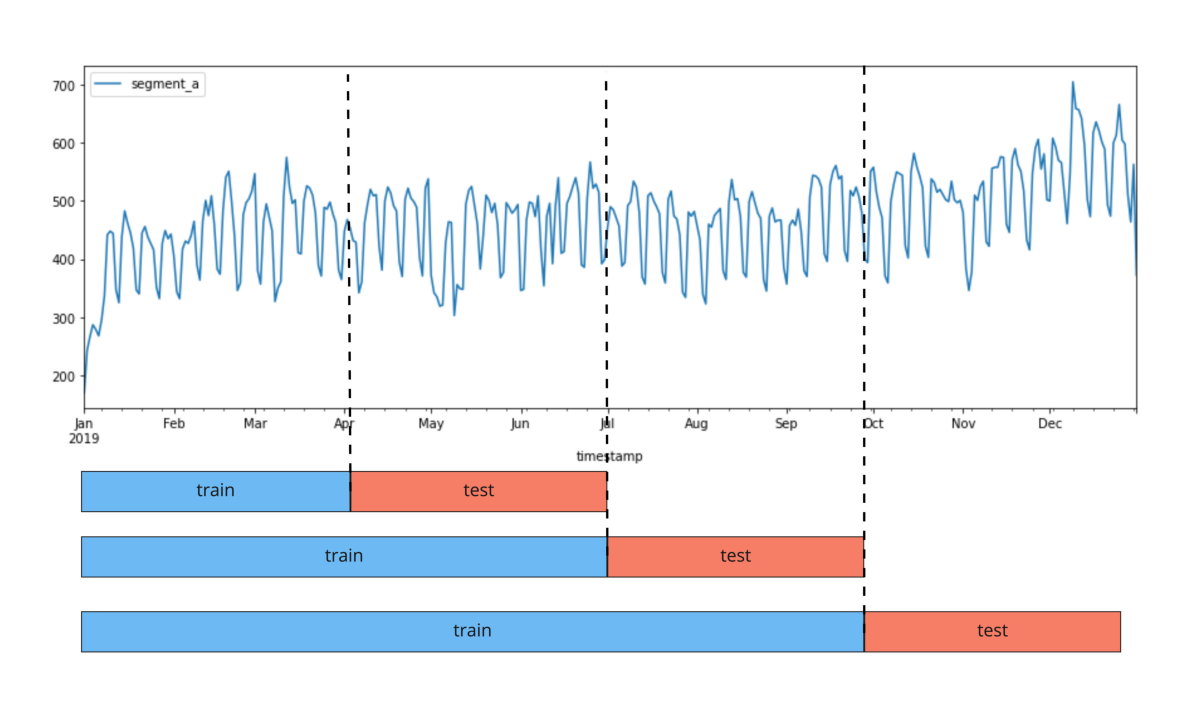

In [ ]:
img = plt.imread(f"./{folder}/backtest.jpg")
plt.figure(figsize=(15, 10))
plt.axis("off")
_ = plt.imshow(img)

Для удобства далее будем называть фолдом конкретную пару подпоследовательностей $(трейн, тест)$

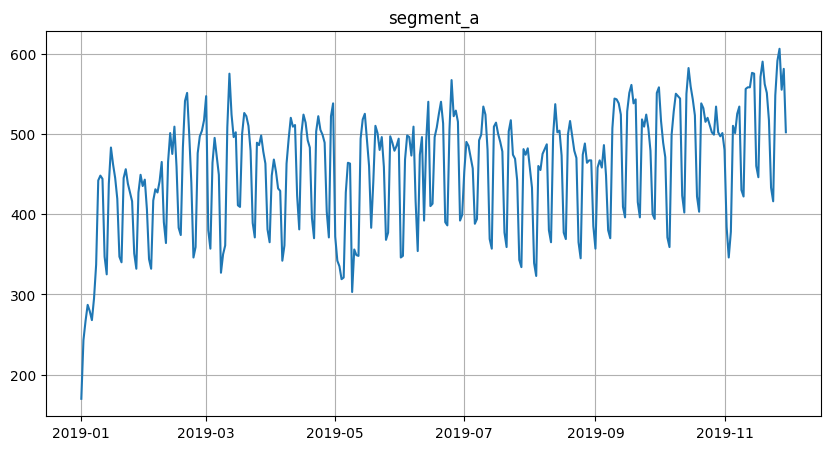

In [ ]:
df = toy_synthetic.copy(deep=True)  # все тот же модельный датасет
df["timestamp"] = pd.to_datetime(df["timestamp"])
df = df.loc[df.segment == "segment_a"]
df = TSDataset.to_dataset(df)
ts = TSDataset(df, freq="D")
ts.plot(segments=["segment_a"])

### 2.2. Как запустить бектест

In [ ]:
horizon = 31  # горизонт предсказаний
model = ProphetModel()  # будем использовать Prophet
transforms = []  # пока оставим пустым
pipeline = Pipeline(model=model, transforms=transforms, horizon=horizon)  # обернули

Метод `backtest` вернет нам 3 (три) датафрейма:
* метрики для каждого фолда и каждого сегмента
* датафрейм с предсказаниями
* датафрейм с информацией о фолдах

In [ ]:
metrics_df, forecast_df, fold_info_df = pipeline.backtest(ts=ts, metrics=[MAE(), MSE(), SMAPE()])

10:33:27 - cmdstanpy - INFO - Chain [1] start processing
10:33:27 - cmdstanpy - INFO - Chain [1] done processing
[Parallel(n_jobs=1)]: Done   1 tasks      | elapsed:    0.1s
10:33:28 - cmdstanpy - INFO - Chain [1] start processing
10:33:28 - cmdstanpy - INFO - Chain [1] done processing
[Parallel(n_jobs=1)]: Done   2 tasks      | elapsed:    0.2s
10:33:28 - cmdstanpy - INFO - Chain [1] start processing
10:33:28 - cmdstanpy - INFO - Chain [1] done processing
[Parallel(n_jobs=1)]: Done   3 tasks      | elapsed:    0.3s
10:33:28 - cmdstanpy - INFO - Chain [1] start processing
10:33:28 - cmdstanpy - INFO - Chain [1] done processing
[Parallel(n_jobs=1)]: Done   4 tasks      | elapsed:    0.4s
10:33:28 - cmdstanpy - INFO - Chain [1] start processing
10:33:28 - cmdstanpy - INFO - Chain [1] done processing
[Parallel(n_jobs=1)]: Done   5 tasks      | elapsed:    0.5s
[Parallel(n_jobs=1)]: Done   5 tasks      | elapsed:    0.5s
[Parallel(n_jobs=1)]: Done   1 tasks      | elapsed:    1.2s
[Paralle

In [ ]:
metrics_df.head()

segment        MAE          MSE     SMAPE  fold_number
0  segment_a  18.735015   588.181343  4.344690            0
0  segment_a  21.027737   673.301206  4.843069            1
0  segment_a  30.073464  1312.689413  6.295410            2
0  segment_a  36.071617  2008.630747  7.443268            3
0  segment_a  32.385662  1892.641539  6.543500            4

In [ ]:
forecast_df.head()

segment      segment_a            
feature    fold_number      target
timestamp                         
2019-06-29           0  394.931502
2019-06-30           0  385.825927
2019-07-01           0  492.928526
2019-07-02           0  509.424666
2019-07-03           0  497.548673

In [ ]:
fold_info_df.head()

train_start_time train_end_time test_start_time test_end_time  fold_number
0       2019-01-01     2019-06-28      2019-06-29    2019-07-29            0
1       2019-01-01     2019-07-29      2019-07-30    2019-08-29            1
2       2019-01-01     2019-08-29      2019-08-30    2019-09-29            2
3       2019-01-01     2019-09-29      2019-09-30    2019-10-30            3
4       2019-01-01     2019-10-30      2019-10-31    2019-11-30            4

Можно также посчитать усредненные по фолдам метрики:

In [ ]:
metrics_df, forecast_df, fold_info_df = pipeline.backtest(
    ts=ts, metrics=[MAE(), MSE(), SMAPE()], aggregate_metrics=True
)

10:33:35 - cmdstanpy - INFO - Chain [1] start processing
10:33:35 - cmdstanpy - INFO - Chain [1] done processing
[Parallel(n_jobs=1)]: Done   1 tasks      | elapsed:    0.1s
10:33:35 - cmdstanpy - INFO - Chain [1] start processing
10:33:35 - cmdstanpy - INFO - Chain [1] done processing
[Parallel(n_jobs=1)]: Done   2 tasks      | elapsed:    0.2s
10:33:35 - cmdstanpy - INFO - Chain [1] start processing
10:33:35 - cmdstanpy - INFO - Chain [1] done processing
[Parallel(n_jobs=1)]: Done   3 tasks      | elapsed:    0.3s
10:33:35 - cmdstanpy - INFO - Chain [1] start processing
10:33:35 - cmdstanpy - INFO - Chain [1] done processing
[Parallel(n_jobs=1)]: Done   4 tasks      | elapsed:    0.4s
10:33:35 - cmdstanpy - INFO - Chain [1] start processing
10:33:35 - cmdstanpy - INFO - Chain [1] done processing
[Parallel(n_jobs=1)]: Done   5 tasks      | elapsed:    0.6s
[Parallel(n_jobs=1)]: Done   5 tasks      | elapsed:    0.6s
[Parallel(n_jobs=1)]: Done   1 tasks      | elapsed:    1.4s
[Paralle

In [ ]:
metrics_df.head()

segment        MAE         MSE     SMAPE
0  segment_a  27.658699  1295.08885  5.893987

In [ ]:
forecast_df.head()

segment      segment_a            
feature    fold_number      target
timestamp                         
2019-06-29           0  394.931502
2019-06-30           0  385.825927
2019-07-01           0  492.928526
2019-07-02           0  509.424666
2019-07-03           0  497.548673

In [ ]:
fold_info_df.head()

train_start_time train_end_time test_start_time test_end_time  fold_number
0       2019-01-01     2019-06-28      2019-06-29    2019-07-29            0
1       2019-01-01     2019-07-29      2019-07-30    2019-08-29            1
2       2019-01-01     2019-08-29      2019-08-30    2019-09-29            2
3       2019-01-01     2019-09-29      2019-09-30    2019-10-30            3
4       2019-01-01     2019-10-30      2019-10-31    2019-11-30            4

### 2.3. Визуализация

Зададим `history_len` и посмотрим, как выглядела история, тест и прогноз

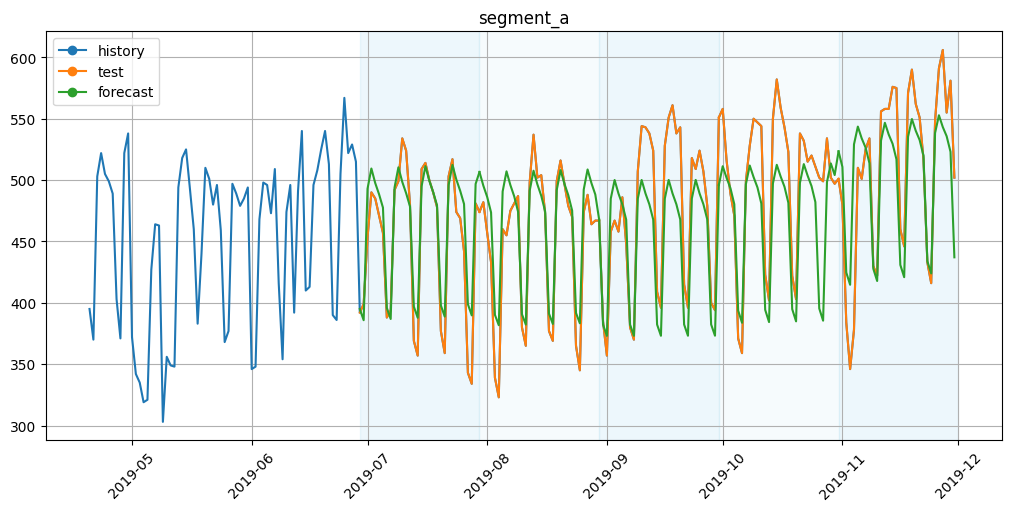

In [ ]:
plot_backtest(forecast_df, ts, history_len=70)

## 3. Разведывательный анализ данных <a class="anchor" id="chapter3"></a>
[Назад к меню](#menu)

Предварительная работа по анализу данных крайне важна во время работы с данными. Данный этап является одним из первых, который исследователь предпринимает во время исследования. Разведывательный анализ данных также называют Exploratory Data Analysis, что зачастую сокращают до EDA.

Коснемся более детально некоторых аспектов процесса EDA; для этого продолжим работать с панельным данными

In [ ]:
classic_df = toy_synthetic.copy(deep=True)
df = TSDataset.to_dataset(classic_df)
ts = TSDataset(df, freq="D")

In [ ]:
classic_df

timestamp    segment  target
0     2019-01-01  segment_a     170
1     2019-01-02  segment_a     243
2     2019-01-03  segment_a     267
3     2019-01-04  segment_a     287
4     2019-01-05  segment_a     279
...          ...        ...     ...
1331  2019-11-26  segment_d     941
1332  2019-11-27  segment_d     949
1333  2019-11-28  segment_d     896
1334  2019-11-29  segment_d     905
1335  2019-11-30  segment_d     721

[1336 rows x 3 columns]

Отрисуем еще раз для удобства

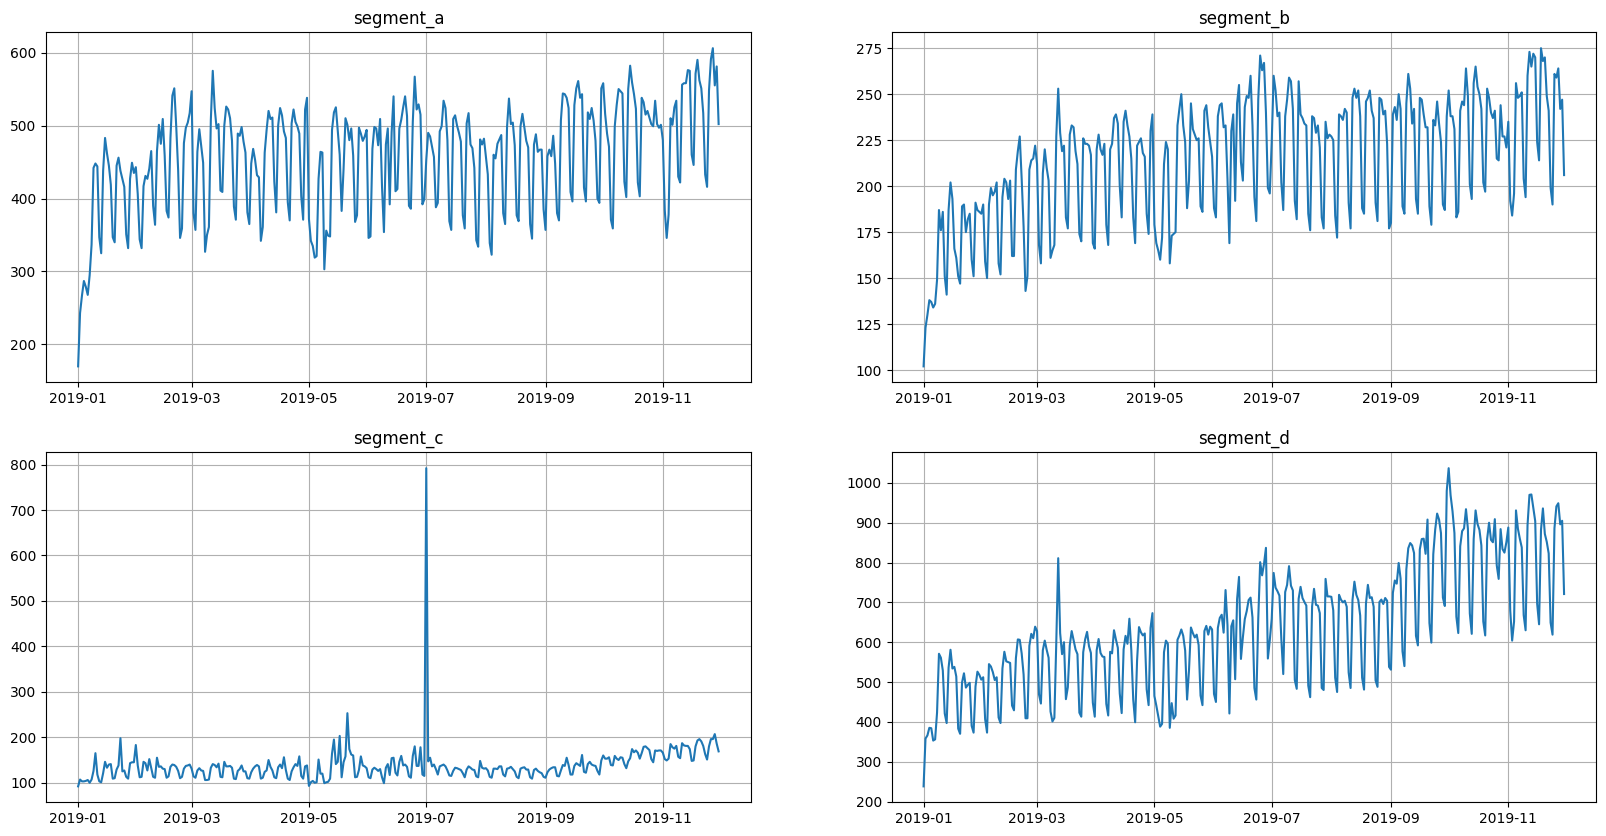

In [ ]:
ts.plot()

Еще можно почитать почему используется и дополнительные фишки более подробно [тут](https://medium.com/its-tinkoff/etna-time-series-analysis-what-why-and-how-e45557af4f6c).

### 3.1. Автокорреляция (ACF) и частичная автокорреляция (PACF)

> Автокорреляция и частная автокорреляция служат мерой связанности между текущими и прошлыми рядами значений и показывает, какие прошлые значения наиболее полезны для предсказания будущих значений.

>Функция автокорреляции (АКФ). При лаге k это корреляция между рядами значений, отстоящих друг от друга на k интервалов, считая значения интервалов в промежутке.

>Функция частной автокорреляции (ЧАКФ). При лаге k это корреляция между рядами значений, отстоящих друг от друга на k интервалов.

Отличительной особенностью ЧАКФ является исключение корреляционной зависимости между наблюдениями внутри лагов, т.е. частная автокорреляционная функция на каждом лаге отличается от обычной автокорреляционной функции на величину удаленных автокорреляций с меньшими временными лагами. Следовательно, частная автокорреляционная функция более точно характеризует автокорреляционные зависимости внутри временного ряда.[5]

Ось x графика ACF показывает лаг, при котором вычисляется автокорреляция; ось y показывает значение корреляции. Например, пик при лаге 1 на графике ЧАКФ показывает сильную корреляцию между значениям ряда и предыдущим значением, пик при лаге 2 показывает сильную корреляцию между каждым значением и значением в более ранний момент на расстоянии 2 от данного и так далее.[6]

По графику ACF можно определить необходимую величину лага для моделей скользящего среднего

По графику PACF можно определить необходимую величину лага для авторегрессионных моделей

[5] Loginom.ru  [6] SPSS, IBM.com

Посмотрим на оба типа зависимости, задав необходимую глубину.

Для построения воспользуемся функцией `acf_plot` - которая может отрисовать функциб автокорреляции и частичную функцию автокорреляции.

Голубое - доверительный интервал, показывающий значимая зависимость или нет.

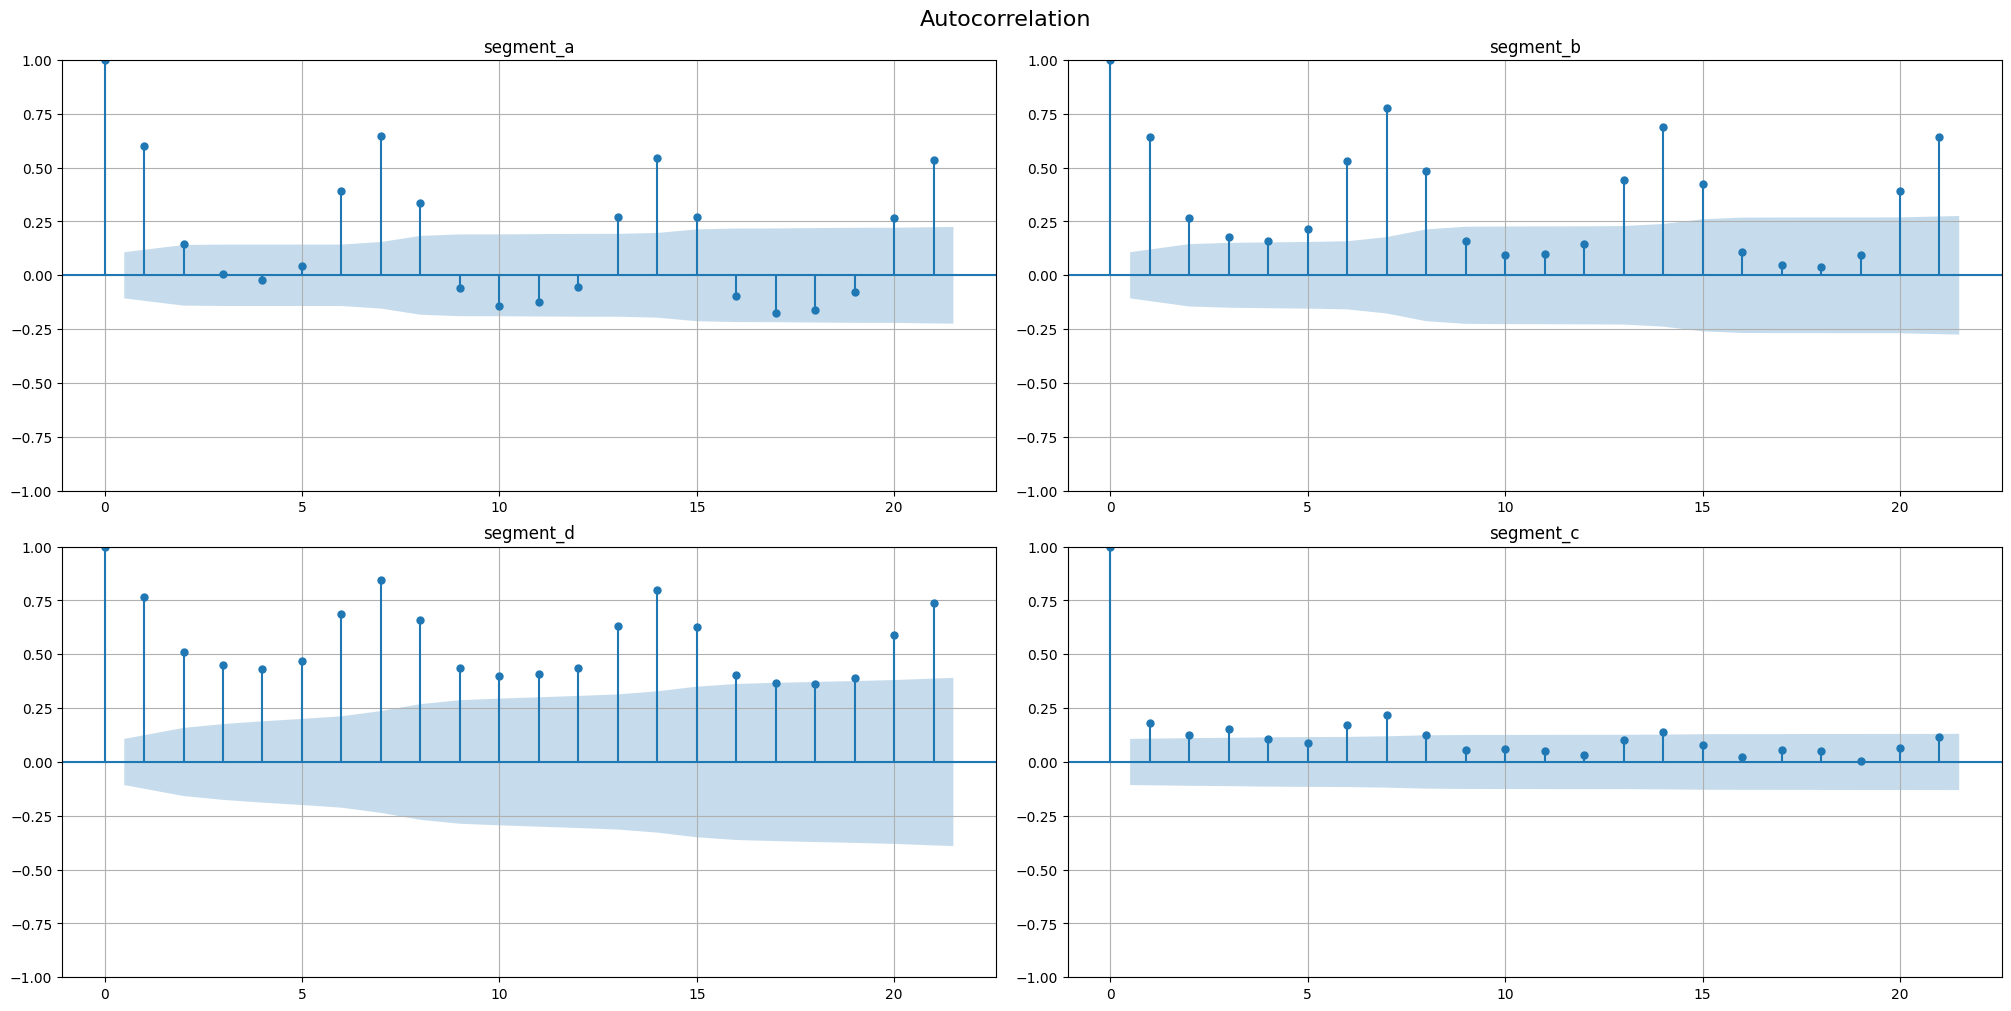

In [ ]:
acf_plot(ts, lags=21)

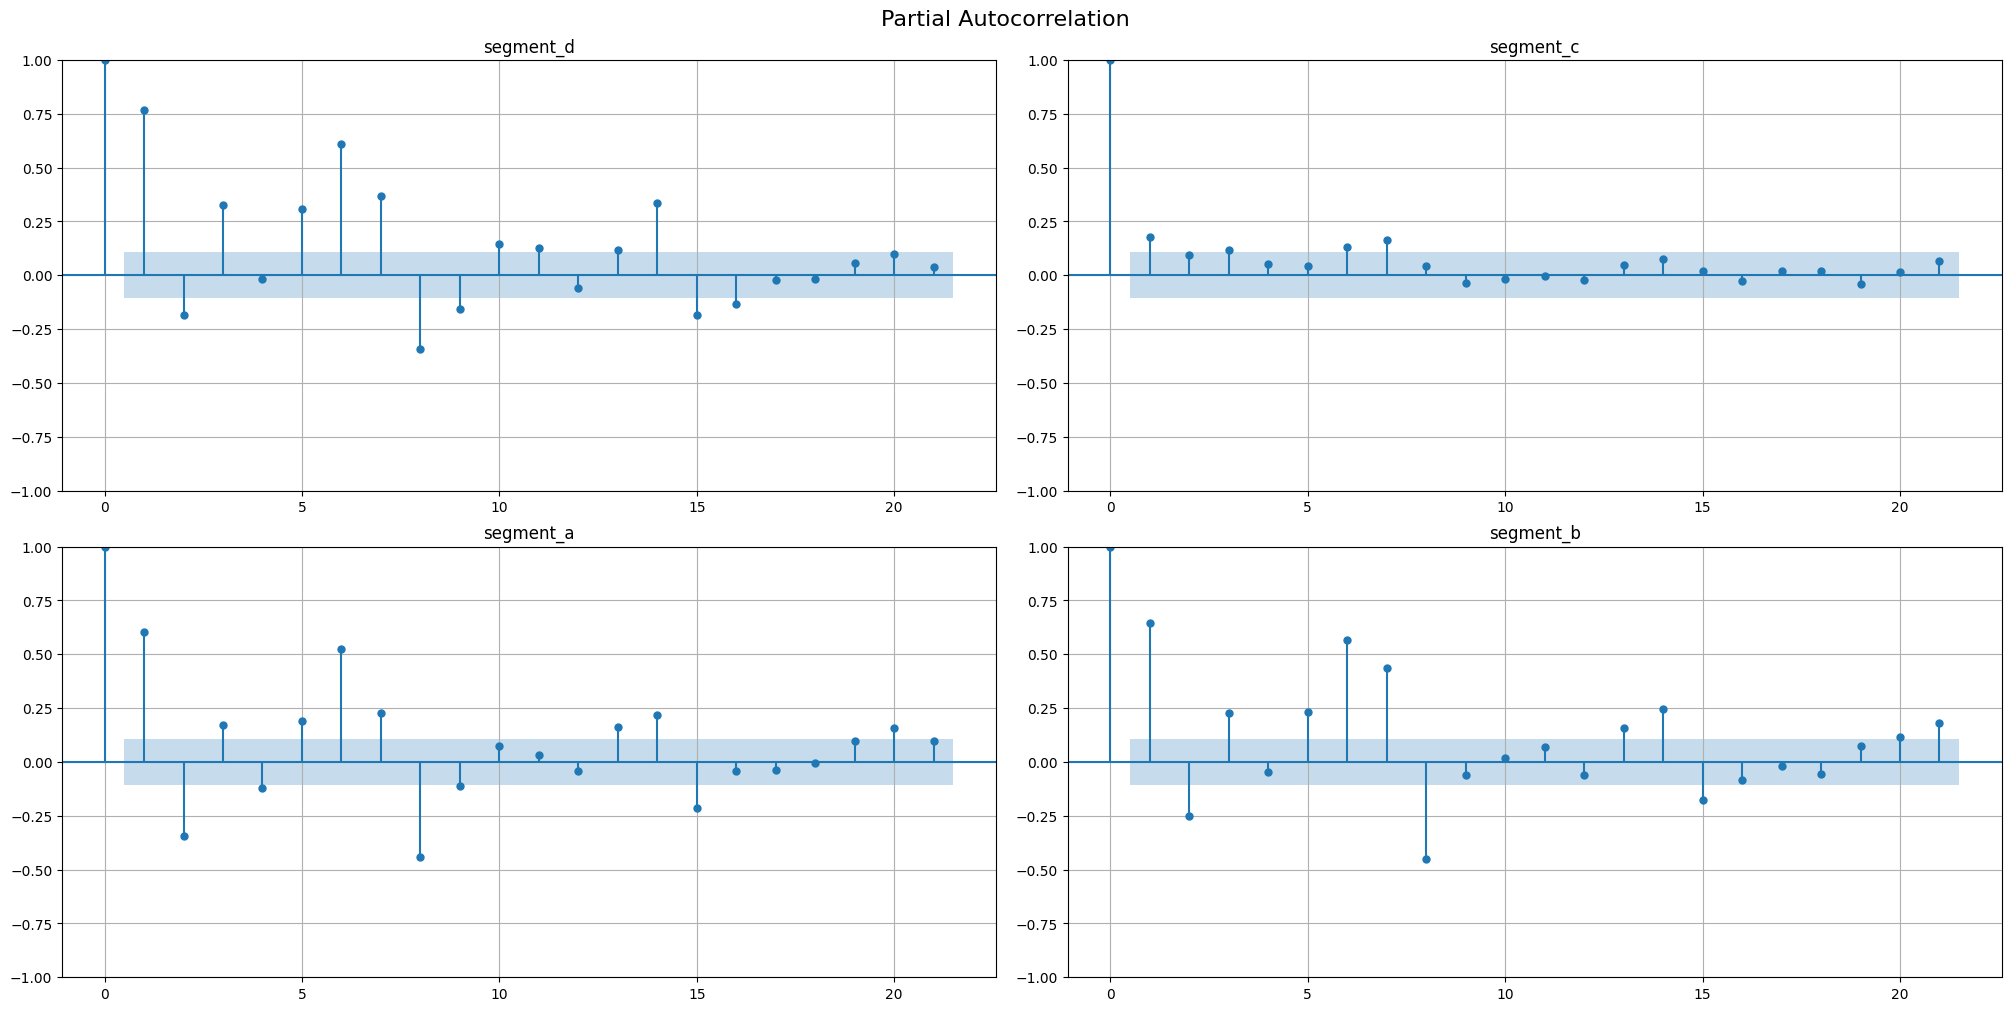

In [ ]:
acf_plot(ts, partial=True, lags=21)

### 3.2. Корреляционная тепловая карта

Попарная корреляция между рядами - для выявления глобально коррелированных друг с другом рядов. Можно также добавить к сравнению ряды, составленные из лагов заданной величины.

In [ ]:
lags = LagTransform(in_column="target", lags=[1, 7], out_column="lag")
ts.fit_transform([lags])

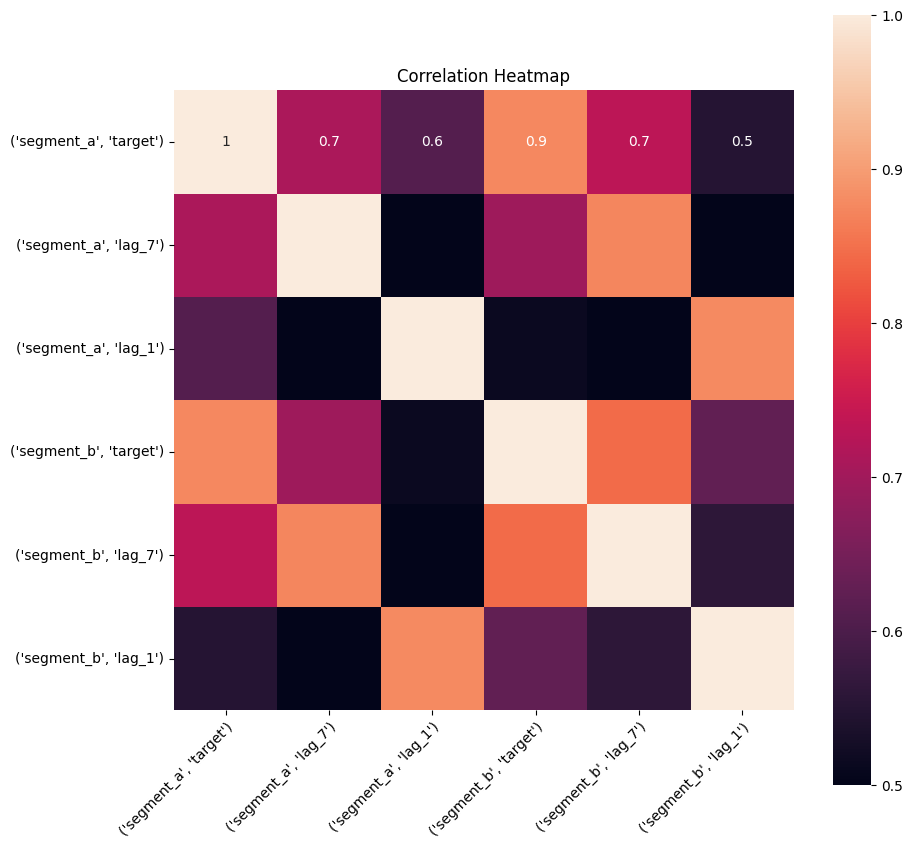

In [ ]:
plot_correlation_matrix(ts, segments=["segment_a", "segment_b"], method="spearman", vmin=0.5, vmax=1)

#### Перейдем к следующей компоненте EDA - настолько важной, что посвятим ей отдельный раздел:

## 4. Выбросы <a class="anchor" id="chapter4"></a>
[Назад к меню](#menu)

В ETNA мы можем детектировать, визуализировать и заменять выбросы. Визуализировать мы можем, в том числе, задетектированные выбросы при помощи `plot_anomalies`.

Выбросы могут быть как точечными, так и представлять из себя целые подпоследовательности. Мы сфокусируемся на первых, и для них предусмотрено 4 метода детекции:

### 4.1. Отклонение от медианных значений, рассчитанных по окну

> Окно просмотра - некоторый непрерывный отрезок данных, который перемещается, "скользит" по всему исходному набору данных

In [ ]:
# сбросим преобразования над ts
classic_df = toy_synthetic.copy(deep=True)
df = TSDataset.to_dataset(classic_df)
ts = TSDataset(df, freq="D")

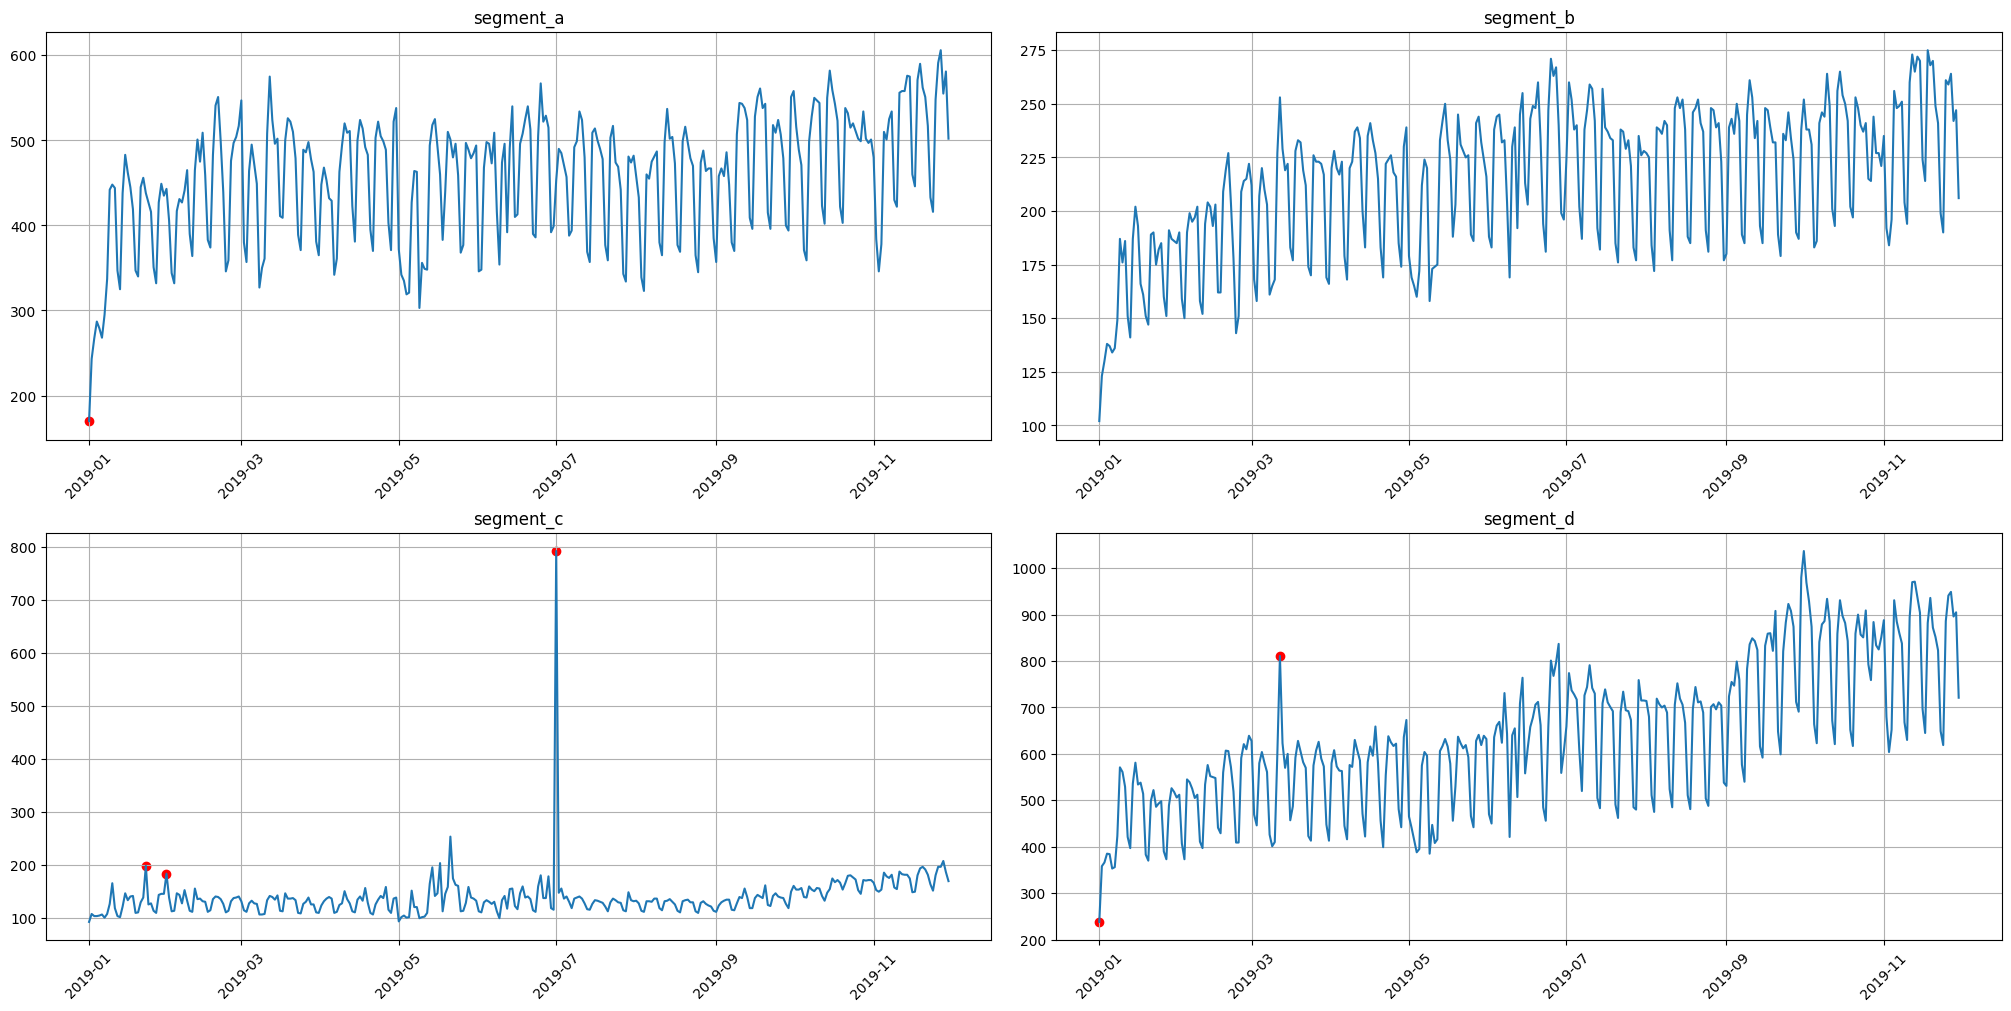

In [ ]:
anomaly_dict = get_anomalies_median(ts, window_size=100)  # задаем размер окна
plot_anomalies(ts, anomaly_dict)

### 4.2. Метод на основе плотности точек
Метрический метод, требующий подбора гиперпараметров под искомые данные (как в примере внизу) - рассчитывать на дефолтные значения не приходится

Как происходит детекция :
    
1. <b>Презумпция виновности</b> - должны определить, снять ли подозрения с точки.
    Для этого для каждой точки мы строим все возможные окна размером ``window_size``, которые содержат эту точку.
2. <b>Если</b> в каком-либо окне содержится как минимум ``n_neighbors`` на расстоянии меньшем чем ``distance_coef * std(series)`` в соответствии с выбранной функцией расстояния ``distance_func``, <b>то</b> искомая точка не является выбросом

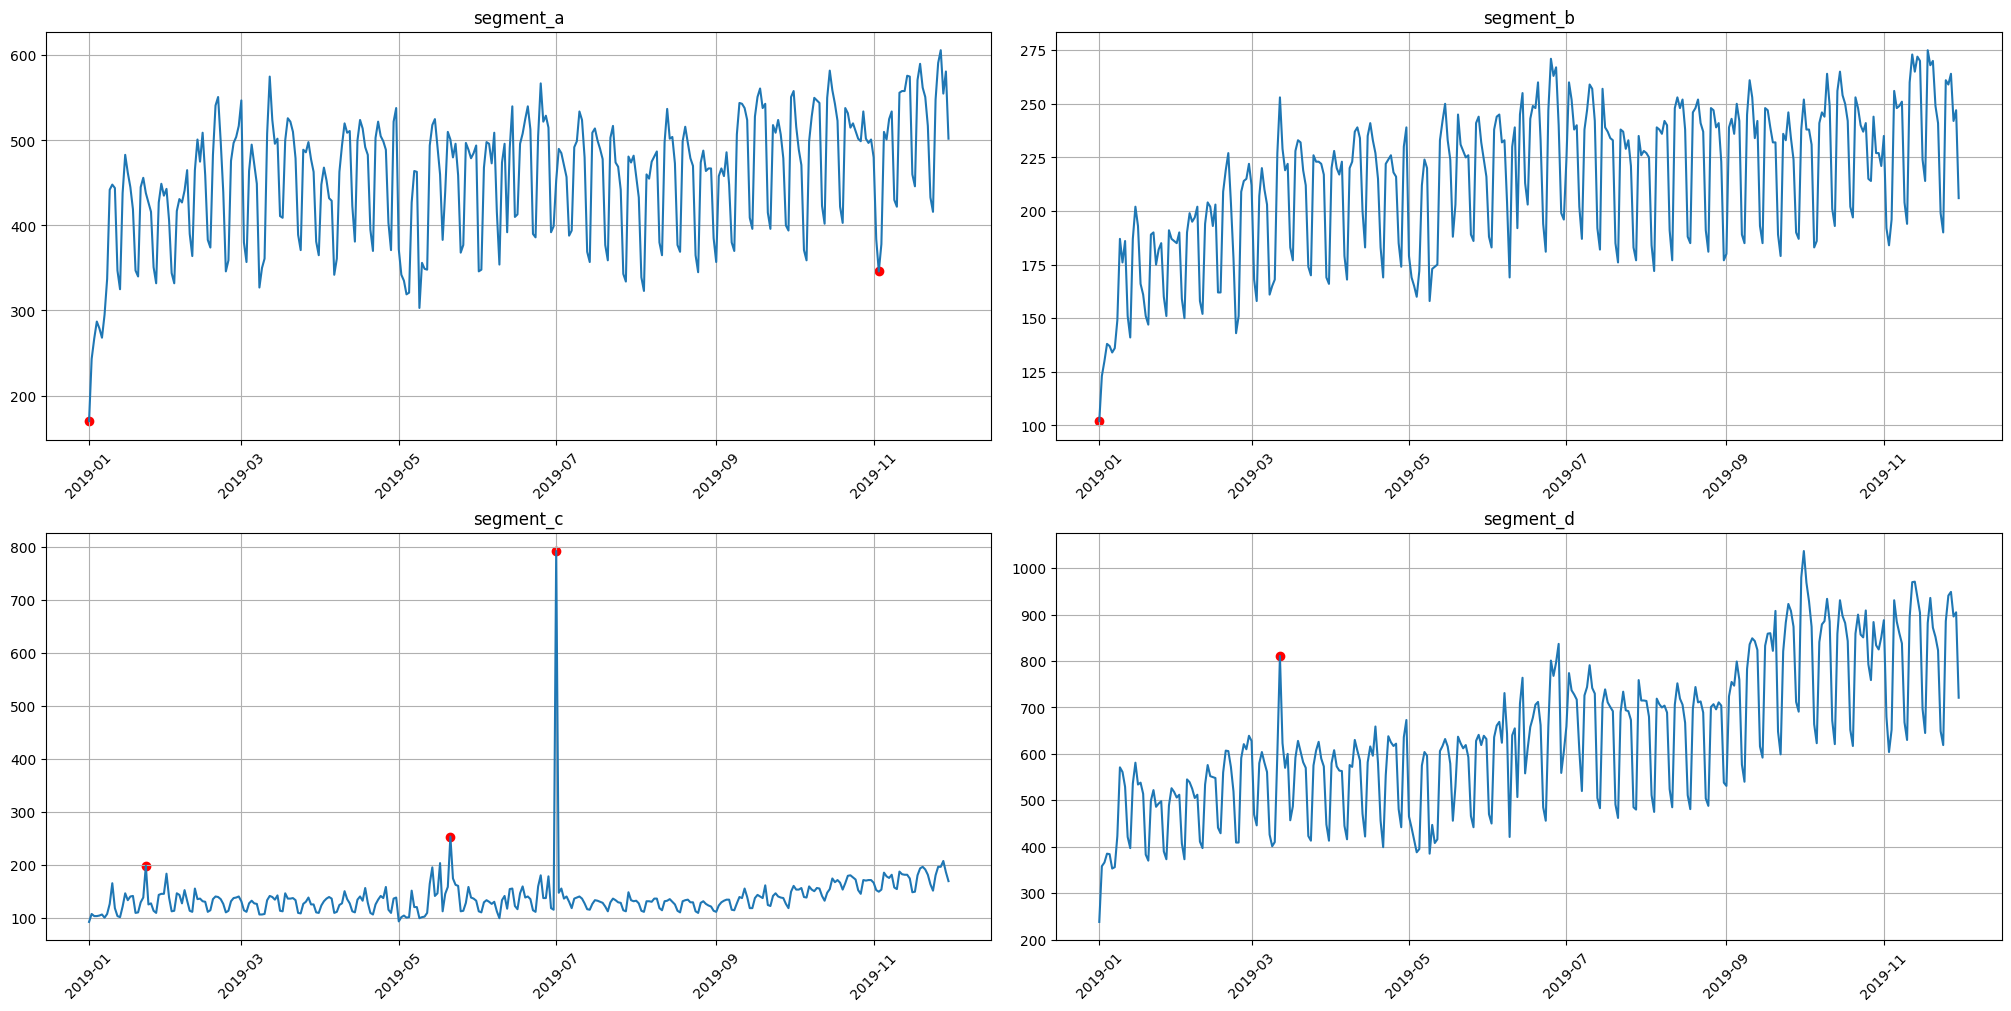

In [ ]:
anomaly_dict = get_anomalies_density(ts, window_size=18, distance_coef=1, n_neighbors=4)
plot_anomalies(ts, anomaly_dict)

### 4.3. Метод на основе предсказаний модели
Выбросами считаются все точки, выпадающие из интервала предсказания некоей модели (`model`).

*NB*: в настоящий момент метод доступен только в связке с `ProphetModel` и `SARIMAXModel`.

// Где модель сильно ошибается, то и выброс

10:33:50 - cmdstanpy - INFO - Chain [1] start processing
10:33:50 - cmdstanpy - INFO - Chain [1] done processing
10:33:50 - cmdstanpy - INFO - Chain [1] start processing
10:33:50 - cmdstanpy - INFO - Chain [1] done processing
10:33:50 - cmdstanpy - INFO - Chain [1] start processing
10:33:50 - cmdstanpy - INFO - Chain [1] done processing
10:33:50 - cmdstanpy - INFO - Chain [1] start processing
10:33:50 - cmdstanpy - INFO - Chain [1] done processing


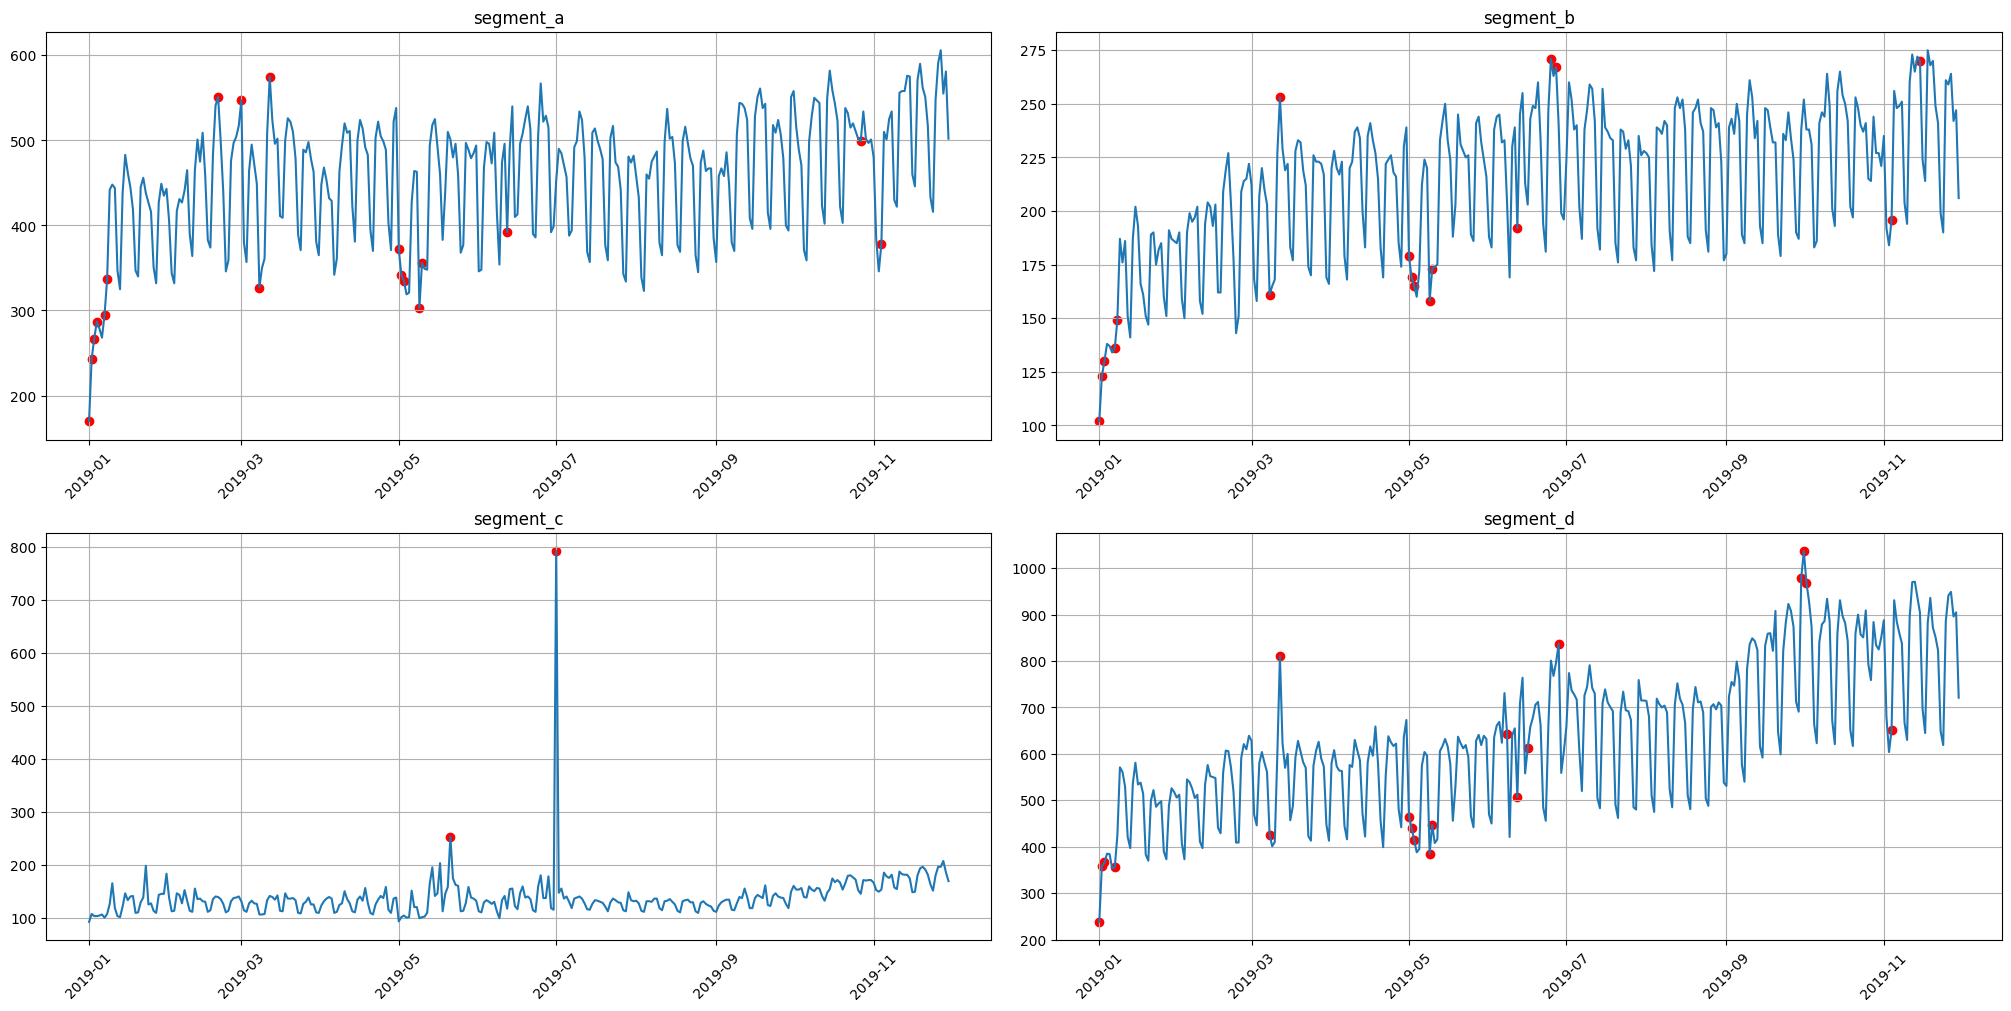

In [ ]:
anomaly_dict = get_anomalies_prediction_interval(ts, model=ProphetModel, interval_width=0.95)

plot_anomalies(ts, anomaly_dict)

### 4.4. Интерактивная визуализация
Качество работы алгоритмов детекции выбросов может существенным образом зависеть от значений гиперпараметров. Чтобы подобрать их наилучшим образом, можно воспользоваться интерактивной визуализацией

Нужно задать **segment**, **method** детекции выбросов и **parameters grid** в формате (min, max, step) для каждого параметра.

In [ ]:
segment = "segment_c"
method = get_anomalies_median
params_bounds = {"window_size": (40, 70, 1), "alpha": (0.1, 4, 0.25)}

В случае проблем с отображением в юпитер-ноутбуке, можно попробовать запустить `!jupyter nbextension enable --py widgetsnbextension`

In [ ]:
plot_anomalies_interactive(ts=ts, segment=segment, method=method, params_bounds=params_bounds)

interactive(children=(IntSlider(value=40, continuous_update=False, description='window_size', max=70, min=40, …

Можно предположить, что лучший набор гиперпараметров в нашем случае выглядит так:

In [ ]:
best_params = {"window_size": 60, "alpha": 2.35}

### 4.5. Замена выбросов
Выбросы можно не только детектировать, но и пытаться заменить на (предположительно) более адекватные значения. Давайте посмотрим как это работает.

Segment с выбросами:

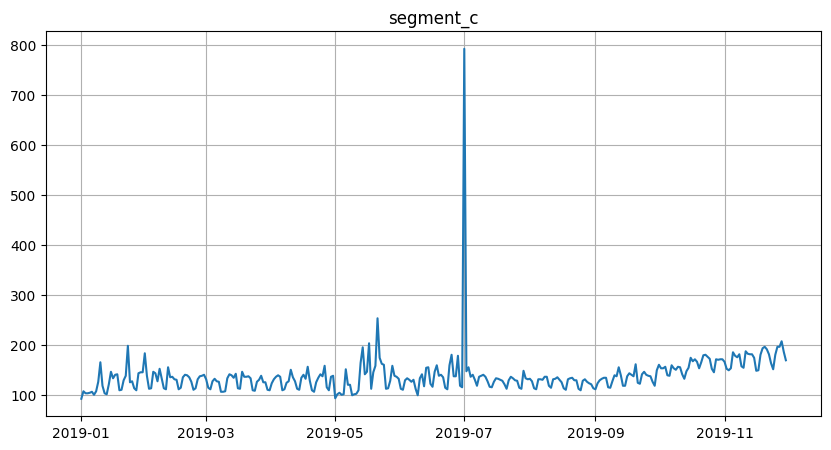

In [ ]:
df = ts[:, segment, :]
ts = TSDataset(df, freq="D")
ts.plot()

Замена выбросов состоит из двух шагов:
1. Заменим задетектированные выбросы на NaNs при помощи экземпляра класса `OutliersTransform`
2. Заполним NaNs при помощи экземпляра класса `TimeSeriesImputerTransform`

Попробуем в качестве метода детекции использовать *median*, в качестве метода заполнения - стратегию *running_mean*:

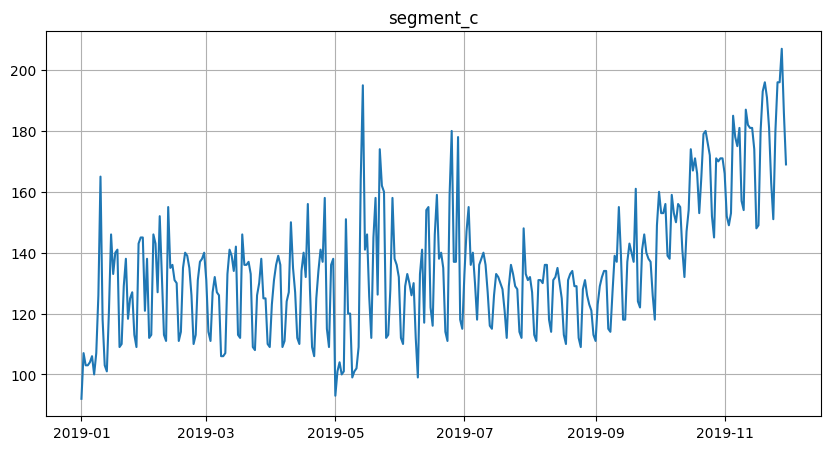

In [ ]:
# Impute outliers with NaNs
outliers_remover = MedianOutliersTransform(in_column="target", **best_params)
# Impute NaNs using the specified strategy
outliers_imputer = TimeSeriesImputerTransform(in_column="target", strategy="running_mean", window=30)
ts.fit_transform([outliers_remover, outliers_imputer])
ts.plot()

Теперь мы можем обучить модель на очищенном датасете, что имеет потенциал улучшить ее качество. Выясним при помощи метрик, справедливо ли это предположение.

In [ ]:
def get_metrics(forecast, test):
    """Compute the metrics on forecast"""
    metrics = {"MAE": MAE(), "MSE": MSE(), "SMAPE": SMAPE()}
    results = dict()
    for name, metric in metrics.items():
        results[name] = metric(y_true=test, y_pred=forecast)["segment_c"]
    return results

In [ ]:
def test_transforms(transforms=[]):
    """Run the experiment on the list of transforms"""
    classic_df = pd.read_csv(f"{folder}/example_dataset.csv")
    df = TSDataset.to_dataset(classic_df[classic_df["segment"] == segment])
    ts = TSDataset(df, freq="D")
    train, test = ts.train_test_split(test_size=HORIZON)

    model = Pipeline(model=MovingAverageModel(window=30), transforms=transforms, horizon=30)

    model.fit(train)
    forecast = model.forecast()
    metrics = get_metrics(forecast, test)
    return metrics

Результаты на исходном датасете:

In [ ]:
test_transforms()

{'MAE': 17.57021827959977,
 'MSE': 405.97295021762625,
 'SMAPE': 10.202976995735366}

Результаты на очищенном датасете (заменяем выбросы на трейне и предсказываем тест):

In [ ]:
transforms = [outliers_remover, outliers_imputer]
test_transforms(transforms)

{'MAE': 17.57021827959977,
 'MSE': 405.97295021762625,
 'SMAPE': 10.202976995735366}

Как мы видим, в нашем случае произошло значительное улучшение метрики. Однако, без дисклеймера все же не обойтись - бывает, что точки, которые мы детектировали как выбросы, являются проявлением сложного неявного процесса, присутствующего во временном ряде. Очевидно, в таком случае стратегия их удаления и/или замены может улучшить качество модели.

## 5. Регрессоры и внешние данные <a class="anchor" id="chapter5"></a>
[Назад к меню](#menu)

### 5.1. Немного теории

#### Что такое регрессоры?

Выше мы практически исключительно работали с тем, что называется **целевым временным рядом**.

> Целевой временной ряд - это временной ряд, который мы хотим предсказать.

Теперь представьте себе, что вы располагаете информацией о будущем, которая может помочь вам с предсказанием целевого ряда. Это может быть информация о празниках, погоде, регулярных событиях, маркетинговых кампаниях и тд. Будем называть их **регрессорами**.

> Регрессоры - временные ряды, которые мы не заинтереснованы прогнозировать, но которые, тем не менее, могут помочь в прогнозировании целевого временного ряда.

Для того, чтобы применить регрессоры в модели и улучшить предсказания, необходимо знать влияние регрессоров на целевой ряд в прошлом, а так же иметь информацию об их значениях в будущем.

#### Что такое дополнительные данные?

Существует (и весьма обширный!) класс данных, которые мы не знаем заранее.
Тем не менее, их использование могло бы помочь нам в нашей задаче предсказания. Назовем такие данные **дополнительными данными**.

К примеру, если много пользователей купили новую модель телефона несколько недель назад, логично ожидать наплыв запросов в поддержку касательно этой модели.

Чтобы использовать дополнительные данные в модели нам необходимо сделать из них регрессоры. К примеру, при помощи экземпляров методов `LagTransform` или `TrendTransform`.

Использование **дополнительныx данных** выходит за рамки семинара, в нем мы сфокусируемся исключительно на **регрессорах**.

### 5.2. Kaggle merch датасет

ETNA позволяет нам работать с регрессорами столь же удобным образом, как и с целевым рядом.

На этот раз займемся предсказанием целевого ряда из соревнования [Tabular Playground Series - Jan 2022](https://www.kaggle.com/c/tabular-playground-series-jan-2022/overview).
Данные содержат дневные продажи мерча – кружки, кепки и стикеры – в двух воображаемых торговых сетях, оперирующих в трех скандинавских странах. В качестве внешних данных будем использовать датасет
[Finland, Norway, and Sweden Weather Data 2015-2019](https://www.kaggle.com/adamwurdits/finland-norway-and-sweden-weather-data-20152019?select=nordics_weather.csv), в котором содержатся дневные данные касательно осадков, глубины снега и температуры воздуха в рассматриваемых странах.

In [ ]:
target_df = kaggle_merch
regressor_df = nordics_weather

Как всегда, вначале сконвертируем данные в форматы, с которыми работает ETNA. Один и тот же код позволит сделать это как для целевых, так и для внешних данных.

In [ ]:
target_df = TSDataset.to_dataset(target_df)
target_df.tail()

segment    Finland_KaggleMart_Kaggle Hat Finland_KaggleMart_Kaggle Mug  \
feature                           target                        target   
timestamp                                                                
2018-12-27                           573                           414   
2018-12-28                           841                           499   
2018-12-29                          1107                           774   
2018-12-30                          1113                           757   
2018-12-31                           822                           469   

segment    Finland_KaggleMart_Kaggle Sticker Finland_KaggleRama_Kaggle Hat  \
feature                               target                        target   
timestamp                                                                    
2018-12-27                               177                          1068   
2018-12-28                               223                          1398   
2018-12-29                               296                          1895   
2018-12-30                               326                          1878   
2018-12-31                               238                          1231   

segment    Finland_KaggleRama_Kaggle Mug Finland_KaggleRama_Kaggle Sticker  \
feature                           target                            target   
timestamp                                                                    
2018-12-27                           652                               308   
2018-12-28                           895                               431   
2018-12-29                          1398                               559   
2018-12-30                          1241                               554   
2018-12-31                           831                               360   

segment    Norway_KaggleMart_Kaggle Hat Norway_KaggleMart_Kaggle Mug  \
feature                          target                       target   
timestamp                                                              
2018-12-27                          898                          568   
2018-12-28                         1162                          731   
2018-12-29                         1650                         1113   
2018-12-30                         1809                         1052   
2018-12-31                         1124                          728   

segment    Norway_KaggleMart_Kaggle Sticker Norway_KaggleRama_Kaggle Hat  \
feature                              target                       target   
timestamp                                                                  
2018-12-27                              270                         1604   
2018-12-28                              361                         2178   
2018-12-29                              518                         2884   
2018-12-30                              500                         2851   
2018-12-31                              351                         2128   

segment    Norway_KaggleRama_Kaggle Mug Norway_KaggleRama_Kaggle Sticker  \
feature                          target                           target   
timestamp                                                                  
2018-12-27                         1108                              436   
2018-12-28                         1333                              662   
2018-12-29                         1816                              874   
2018-12-30                         1935                              833   
2018-12-31                         1383                              561   

segment    Sweden_KaggleMart_Kaggle Hat Sweden_KaggleMart_Kaggle Mug  \
feature                          target                       target   
timestamp                                                              
2018-12-27                          672                          420   
2018-12-28                          874                          555   
20

Таргет заканчивается в 2018, в то время как внешние данные - в 2019,
таким образом мы располагаем некоторой внешней информацией на год вперед.
Соответственно, наши внешние данные содержат исключительно готовые регрессоры.

In [ ]:
regressor_df = TSDataset.to_dataset(regressor_df)
regressor_df.tail()

segment    Finland_KaggleMart_Kaggle Hat                                  \
feature                    precipitation  snow_depth      tavg      tmax   
timestamp                                                                  
2019-12-27                      0.028249  109.550000 -8.529630 -3.161039   
2019-12-28                      0.789266  116.421053 -9.107407 -4.703947   
2019-12-29                      4.976966  117.117647 -0.418519  1.264052   
2019-12-30                      1.229775  160.500000  2.292593  3.344156   
2019-12-31                      0.225281  124.647059 -2.859259  1.580519   

segment               Finland_KaggleMart_Kaggle Mug                        \
feature          tmin                 precipitation  snow_depth      tavg   
timestamp                                                                   
2019-12-27 -10.895425                      0.028249  109.550000 -8.529630   
2019-12-28 -15.288889                      0.789266  116.421053 -9.107407   
2019-12-29  -7.722078                      4.976966  117.117647 -0.418519   
2019-12-30  -0.202632                      1.229775  160.500000  2.292593   
2019-12-31  -6.921569                      0.225281  124.647059 -2.859259   

segment                          ... Sweden_KaggleRama_Kaggle Mug              \
feature         tmax       tmin  ...                precipitation  snow_depth   
timestamp                        ...                                            
2019-12-27 -3.161039 -10.895425  ...                     0.105079  141.220930   
2019-12-28 -4.703947 -15.288889  ...                     1.117688  142.955224   
2019-12-29  1.264052  -7.722078  ...                     1.758669  136.725146   
2019-12-30  3.344156  -0.202632  ...                     0.561996  120.740741   
2019-12-31  1.580519  -6.921569  ...                     0.848161  131.583333   

segment                                   Sweden_KaggleRama_Kaggle Sticker  \
feature         tavg      tmax       tmin                    precipitation   
timestamp                                                                    
2019-12-27 -4.277778 -2.391204  -8.993458                         0.105079   
2019-12-28 -3.866667 -3.006542 -11.593056                         1.117688   
2019-12-29  1.755556  3.692056  -4.516204                         1.758669   
2019-12-30  4.900000  6.135648   1.859070                         0.561996   
2019-12-31  1.722222  4.376606  -2.290278                         0.848161   

segment                                                
feature     snow_depth      tavg      tmax       tmin  
timestamp                                              
2019-12-27  141.220930 -4.277778 -2.391204  -8.993458  
2019-12-28  142.955224 -3.866667 -3.006542 -11.593056  
2019-12-29  136.725146  1.755556  3.692056  -4.516204  
2019-12-30  120.740741  4.900000  6.135648   1.859070  
2019-12-31  131.583333  1.722222  4.376606  -2.290278  

[5 rows x 90 columns]

Нам необходимо создать TSDataset, который будет содержать как целевой ряд, так и внешние данные. По сигнатуре класса TSDataset мы должны передать целевой ряд в качестве аргумента `df`, а внешние данные в качестве аргумента `df_exog`. Мы используем параметр `known_future` с тем, чтобы разделить столбцы df_exog на те, что содержат **регрессоры** (в данном случае все), и те, что содержат **дополнительные данные**.

In [ ]:
ts = TSDataset(df=target_df, freq="D", df_exog=regressor_df, known_future="all")
ts.head()

segment    Finland_KaggleMart_Kaggle Hat                                \
feature                    precipitation  snow_depth target       tavg   
timestamp                                                                
2015-01-01                      1.714141  284.545455  520.0   1.428571   
2015-01-02                     10.016667  195.000000  493.0   0.553571   
2015-01-03                      3.956061  284.294118  535.0  -1.739286   
2015-01-04                      0.246193  260.772727  544.0  -7.035714   
2015-01-05                      0.036364  236.900000  378.0 -17.164286   

segment                         Finland_KaggleMart_Kaggle Mug              \
feature         tmax       tmin                 precipitation  snow_depth   
timestamp                                                                   
2015-01-01  2.912739  -1.015287                      1.714141  284.545455   
2015-01-02  2.358599  -0.998718                     10.016667  195.000000   
2015-01-03  0.820382  -3.463871                      3.956061  284.294118   
2015-01-04 -3.110828  -9.502581                      0.246193  260.772727   
2015-01-05 -8.727564 -19.004487                      0.036364  236.900000   

segment                       ... Sweden_KaggleRama_Kaggle Mug        \
feature    target       tavg  ...                       target  tavg   
timestamp                     ...                                      
2015-01-01  329.0   1.428571  ...                        706.0  3.47   
2015-01-02  318.0   0.553571  ...                        653.0  3.80   
2015-01-03  360.0  -1.739286  ...                        734.0  1.61   
2015-01-04  332.0  -7.035714  ...                        657.0 -1.35   
2015-01-05  243.0 -17.164286  ...                        512.0 -4.27   

segment                        Sweden_KaggleRama_Kaggle Sticker             \
feature         tmax      tmin                    precipitation snow_depth   
timestamp                                                                    
2015-01-01  5.415354  0.221569                         3.642278  84.924623   
2015-01-02  5.097244  0.294882                         2.414665  67.043702   
2015-01-03  2.140392 -1.776680                         0.212793  79.945946   
2015-01-04 -0.648425 -5.173123                         0.226833  78.997290   
2015-01-05 -3.027451 -9.544488                         0.515601  79.736148   

segment                                      
feature    target  tavg      tmax      tmin  
timestamp                                    
2015-01-01  324.0  3.47  5.415354  0.221569  
2015-01-02  293.0  3.80  5.097244  0.294882  
2015-01-03  319.0  1.61  2.140392 -1.776680  
2015-01-04  300.0 -1.35 -0.648425 -5.173123  
2015-01-05  227.0 -4.27 -3.027451 -9.544488  

[5 rows x 108 columns]

#### Выборочные отрисовки вспомогательных датасетов:

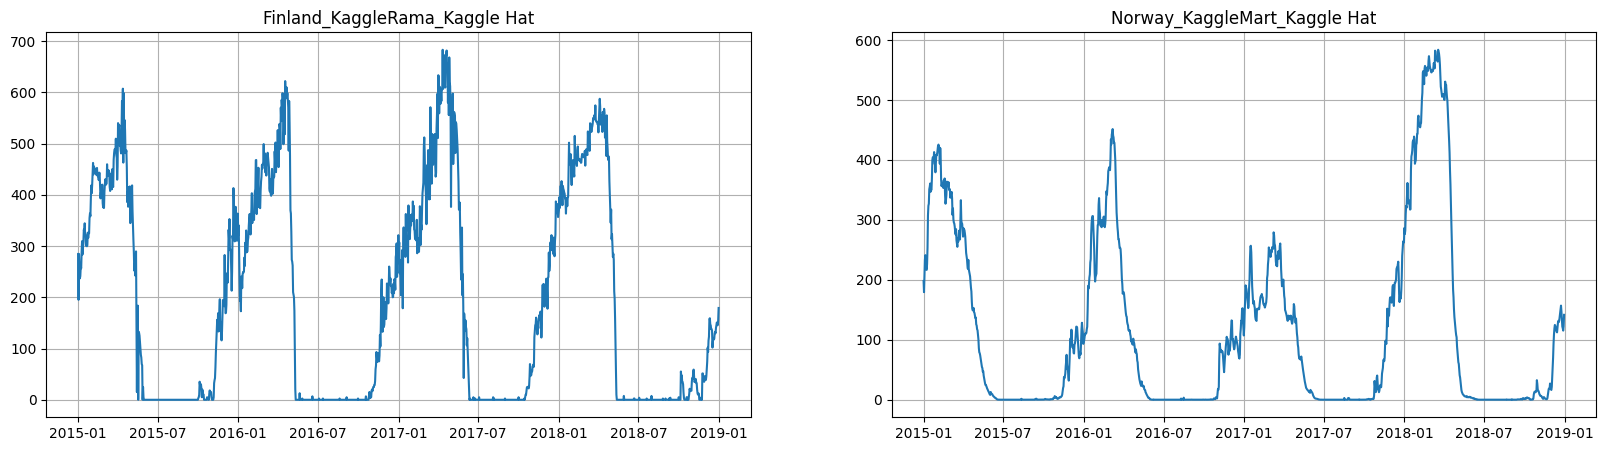

In [ ]:
ts.plot(column="snow_depth", n_segments=2)

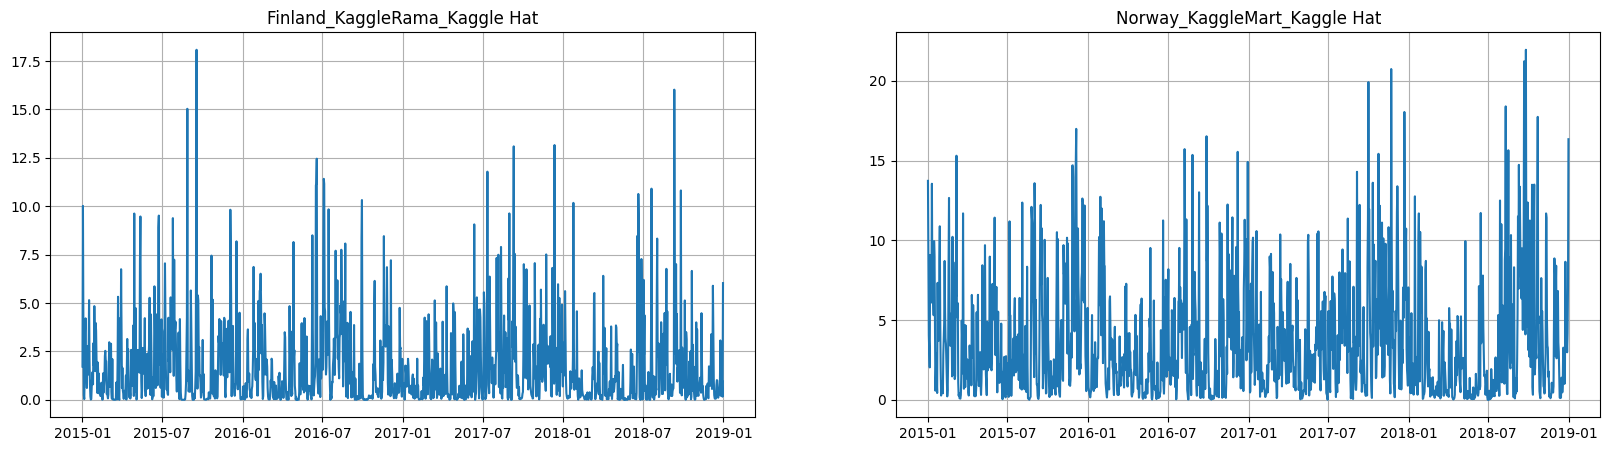

In [ ]:
ts.plot(column="precipitation", n_segments=2)

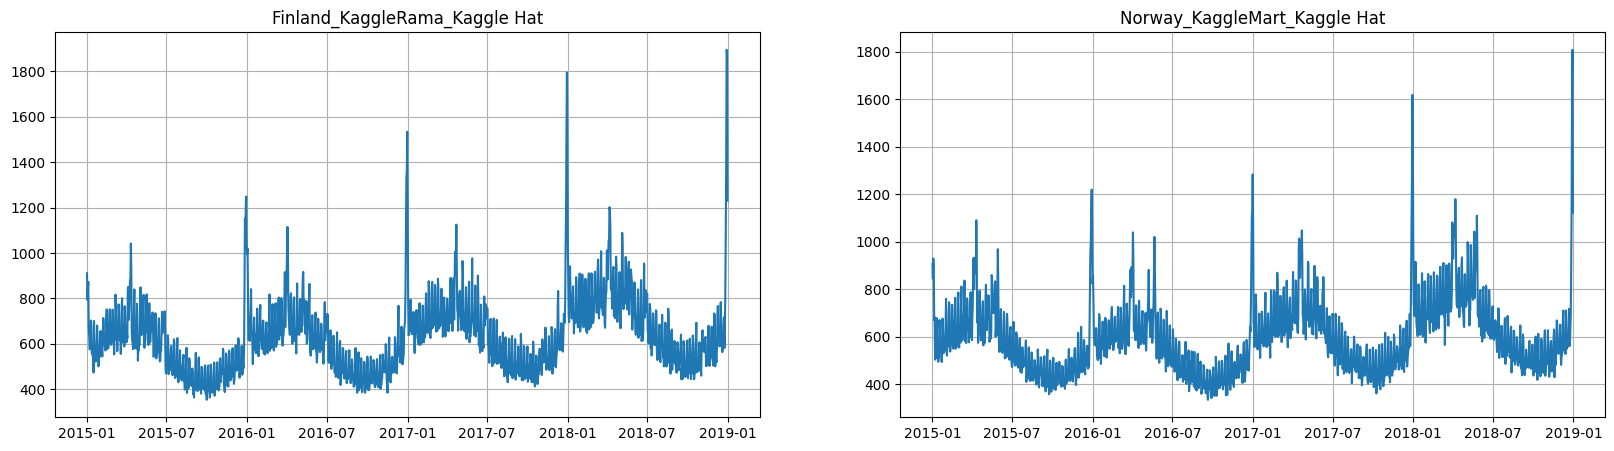

In [ ]:
ts.plot(column="target", n_segments=2)

### 5.3. Пример работы пайпланов

Будем использовать `LinearPerSegmentModel`, это несложная модель, позволяющая работать с регрессорами.

*NB*: некоторые модели не поддерживают работу с регрессорами, и выдадут соответствующее предупреждение.

Наша задача состоит в том, чтобы предсказать продажи мерча на год вперед при помощи регрессоров, дающих информацию о погоде.

In [ ]:
HORIZON = 365
model = LinearPerSegmentModel()

ETNA позволяет задать конфигурации преобразований (transforms) для работы с внешними данными точно таким же образом, как и для работы с целевым рядом.

In [ ]:
transforms = [
    LagTransform(
        in_column="target",
        lags=list(range(HORIZON, HORIZON + 28)),
        out_column="target_lag",
    ),
    LagTransform(in_column="tavg", lags=list(range(1, 3)), out_column="tavg_lag"),
    MeanTransform(in_column="tavg", window=7, out_column="tavg_mean"),
    MeanTransform(
        in_column="target_lag_365",
        out_column="target_mean",
        window=104,
        seasonality=7,
    ),
    DateFlagsTransform(
        day_number_in_week=True,
        day_number_in_month=True,
        is_weekend=True,
        special_days_in_week=[4],
        out_column="date_flag",
    ),
    HolidayTransform(iso_code="SWE", out_column="SWE_holidays"),
    HolidayTransform(iso_code="NOR", out_column="NOR_holidays"),
    HolidayTransform(iso_code="FIN", out_column="FIN_holidays"),
    LagTransform(
        in_column="SWE_holidays",
        lags=list(range(2, 6)),
        out_column="SWE_holidays_lag",
    ),
    LagTransform(
        in_column="NOR_holidays",
        lags=list(range(2, 6)),
        out_column="NOR_holidays_lag",
    ),
    LagTransform(
        in_column="FIN_holidays",
        lags=list(range(2, 6)),
        out_column="FIN_holidays_lag",
    ),
    FilterFeaturesTransform(exclude=["precipitation", "snow_depth", "tmin", "tmax"]),
]

Дальнейшие шаги идентичны пайплайну работы исключительно с целевым рядом:

In [ ]:
pipeline = Pipeline(model=model, transforms=transforms, horizon=HORIZON)

In [ ]:
metrics, forecasts, _ = pipeline.backtest(ts, metrics=[SMAPE()], aggregate_metrics=True, n_folds=2)

[Parallel(n_jobs=1)]: Done   1 tasks      | elapsed:    2.1s
[Parallel(n_jobs=1)]: Done   2 tasks      | elapsed:    4.4s
[Parallel(n_jobs=1)]: Done   2 tasks      | elapsed:    4.4s
[Parallel(n_jobs=1)]: Done   1 tasks      | elapsed:    1.9s
[Parallel(n_jobs=1)]: Done   2 tasks      | elapsed:    4.2s
[Parallel(n_jobs=1)]: Done   2 tasks      | elapsed:    4.2s
[Parallel(n_jobs=1)]: Done   1 tasks      | elapsed:    0.3s
[Parallel(n_jobs=1)]: Done   2 tasks      | elapsed:    0.5s
[Parallel(n_jobs=1)]: Done   2 tasks      | elapsed:    0.5s


In [ ]:
metrics

segment      SMAPE
0       Finland_KaggleMart_Kaggle Hat   6.809976
1       Finland_KaggleMart_Kaggle Mug   7.897876
2   Finland_KaggleMart_Kaggle Sticker   7.566816
3       Finland_KaggleRama_Kaggle Hat   6.714908
4       Finland_KaggleRama_Kaggle Mug   7.443409
5   Finland_KaggleRama_Kaggle Sticker   7.540571
6        Norway_KaggleMart_Kaggle Hat   9.335215
7        Norway_KaggleMart_Kaggle Mug  11.929340
8    Norway_KaggleMart_Kaggle Sticker  11.455042
9        Norway_KaggleRama_Kaggle Hat   8.976252
10       Norway_KaggleRama_Kaggle Mug  11.691445
11   Norway_KaggleRama_Kaggle Sticker  11.594758
12       Sweden_KaggleMart_Kaggle Hat   6.837174
13       Sweden_KaggleMart_Kaggle Mug   7.319936
14   Sweden_KaggleMart_Kaggle Sticker   6.973164
15       Sweden_KaggleRama_Kaggle Hat   6.366672
16       Sweden_KaggleRama_Kaggle Mug   6.994042
17   Sweden_KaggleRama_Kaggle Sticker   7.081337

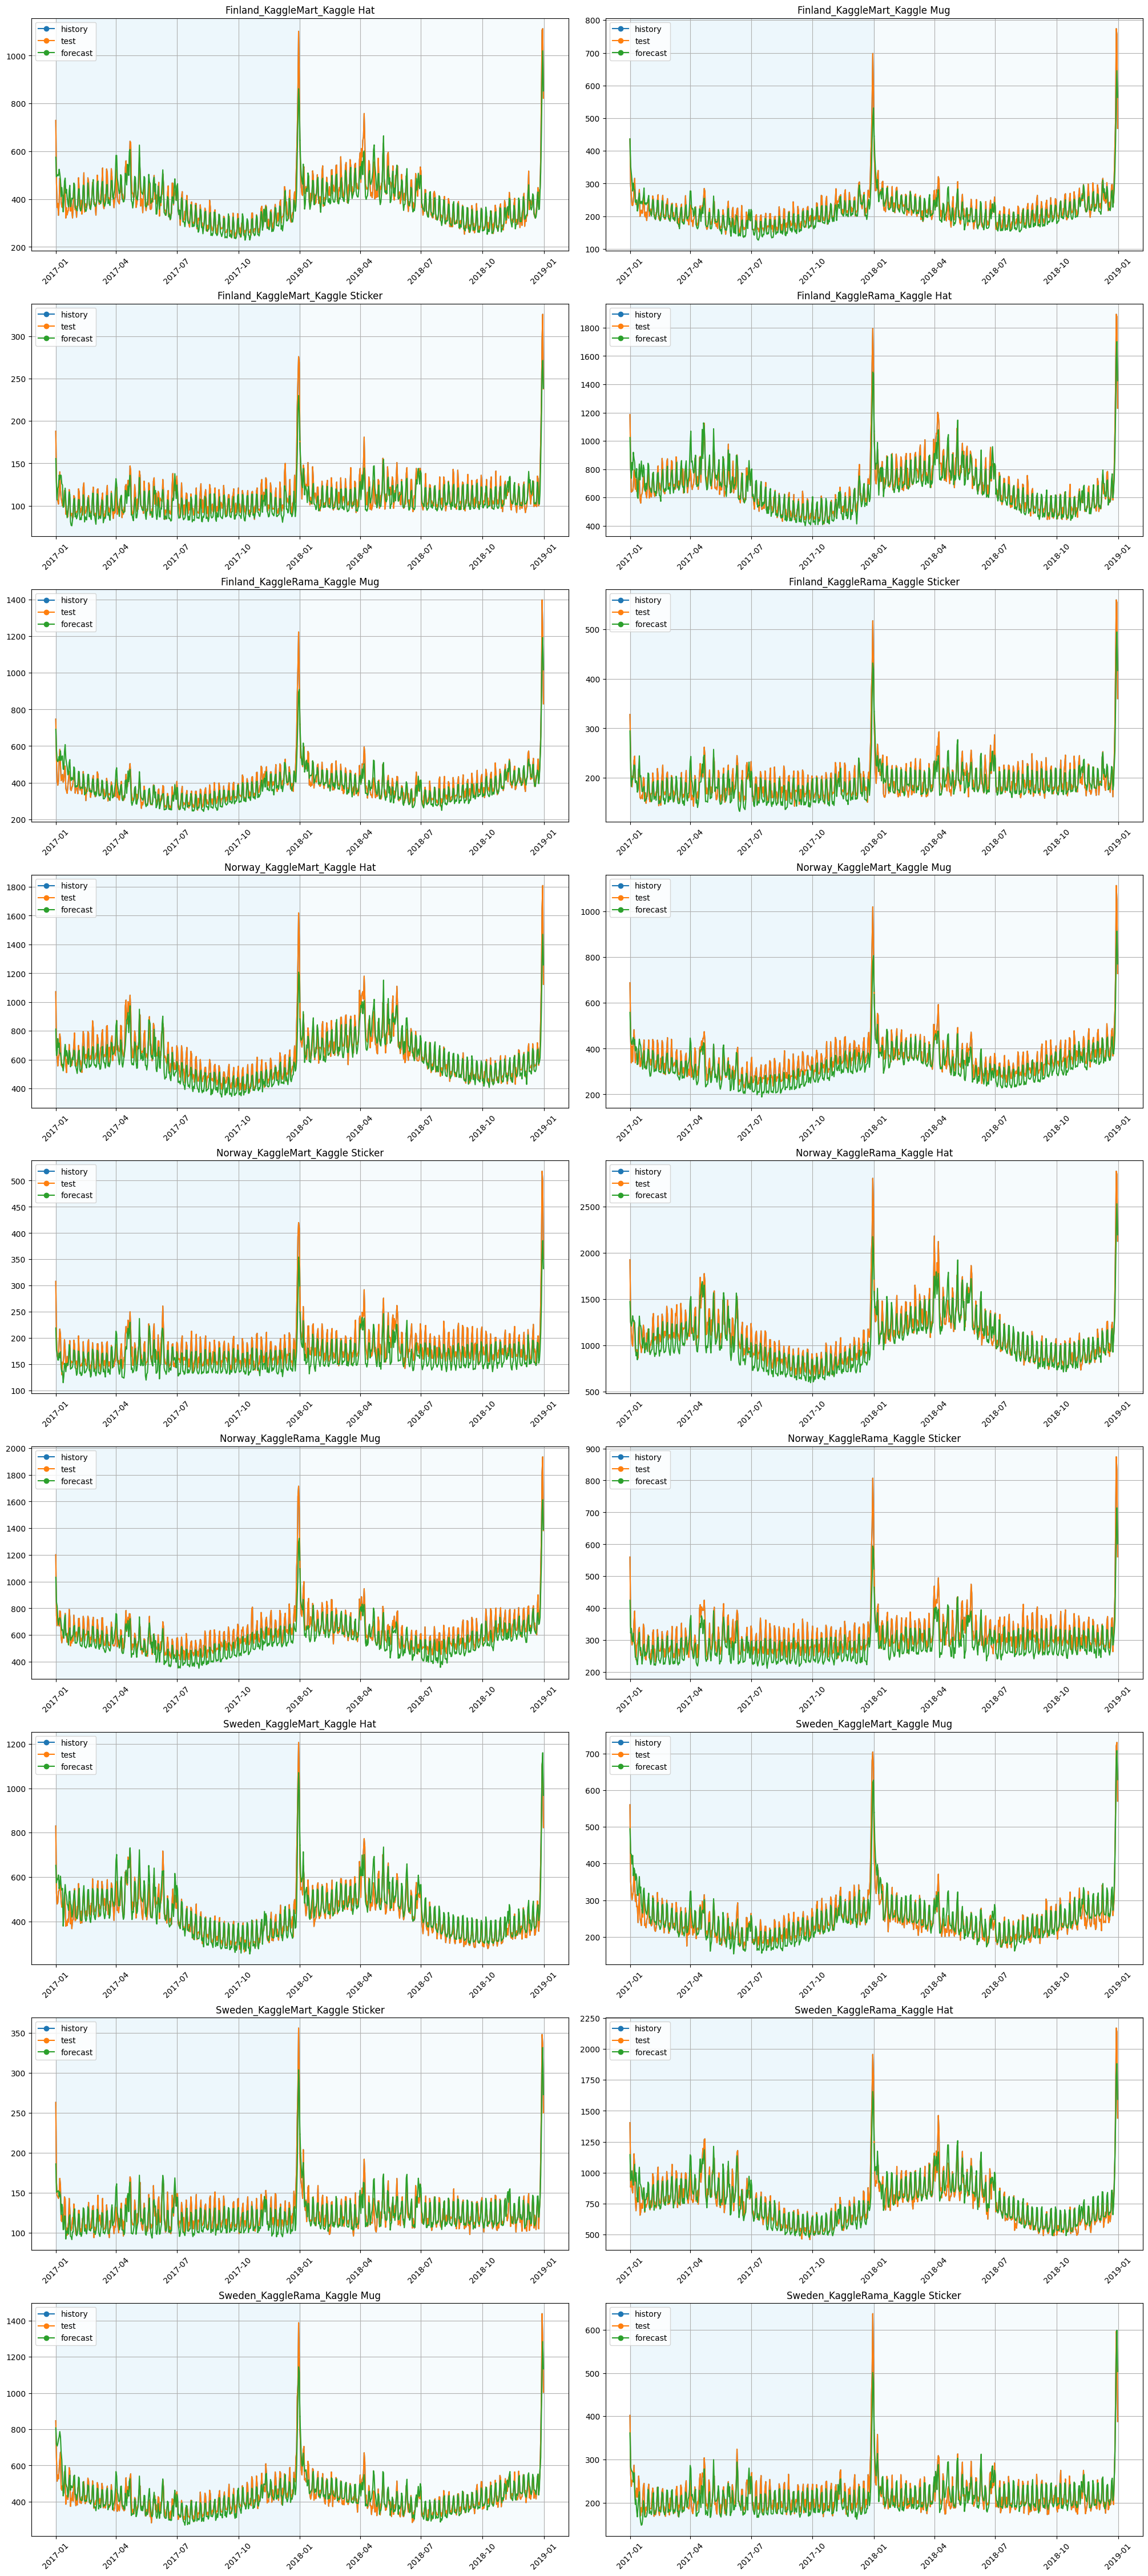

In [ ]:
plot_backtest(forecasts, ts)

## 6. Ансамбли <a class="anchor" id="chapter6"></a>
[Назад к меню](#menu)

Вернемся к австралийским винам

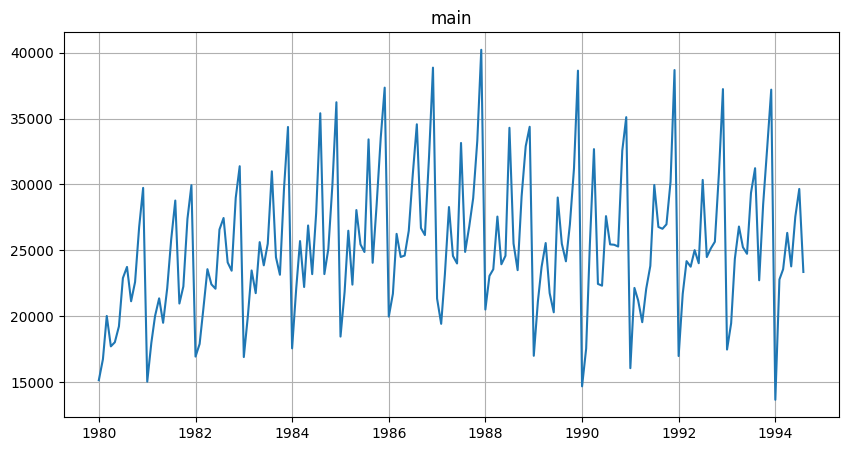

In [ ]:
original_df = australian_wine.copy(deep=True)
original_df["timestamp"] = pd.to_datetime(original_df["month"])
original_df["target"] = original_df["sales"]
original_df.drop(columns=["month", "sales"], inplace=True)
original_df["segment"] = "main"
original_df.head()
df = TSDataset.to_dataset(original_df)
ts = TSDataset(df=df, freq="MS")
ts.plot()

Построим несколько пайплайнов

In [ ]:
HORIZON = 3
N_FOLDS = 5

naive_pipeline = Pipeline(model=NaiveModel(lag=12), transforms=[], horizon=HORIZON)

seasonalma_pipeline = Pipeline(
    model=SeasonalMovingAverageModel(window=5, seasonality=12),
    transforms=[],
    horizon=HORIZON,
)

catboost_pipeline = Pipeline(
    model=CatBoostMultiSegmentModel(),
    transforms=[LagTransform(lags=[6, 7, 8, 9, 10, 11, 12], in_column="target")],
    horizon=HORIZON,
)

pipeline_names = ["naive", "moving average", "catboost"]
pipelines = [naive_pipeline, seasonalma_pipeline, catboost_pipeline]

И посмотрим на их показатели на бэктесте

In [ ]:
metrics = []
for pipeline in pipelines:
    metrics.append(
        pipeline.backtest(
            ts=ts,
            metrics=[MAE(), MSE(), MAPE()],
            n_folds=N_FOLDS,
            aggregate_metrics=True,
            n_jobs=5,
        )[
            0
        ].iloc[:, 1:]
    )

[Parallel(n_jobs=5)]: Using backend MultiprocessingBackend with 5 concurrent workers.
[Parallel(n_jobs=5)]: Done   1 tasks      | elapsed:    8.0s
[Parallel(n_jobs=5)]: Done   2 out of   5 | elapsed:   15.1s remaining:   22.6s
[Parallel(n_jobs=5)]: Done   3 out of   5 | elapsed:   22.0s remaining:   14.7s
[Parallel(n_jobs=5)]: Done   5 out of   5 | elapsed:   36.4s finished
[Parallel(n_jobs=5)]: Using backend MultiprocessingBackend with 5 concurrent workers.
[Parallel(n_jobs=5)]: Done   1 tasks      | elapsed:    0.1s
[Parallel(n_jobs=5)]: Done   2 out of   5 | elapsed:    0.1s remaining:    0.1s
[Parallel(n_jobs=5)]: Done   3 out of   5 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=5)]: Done   5 out of   5 | elapsed:    0.1s finished
[Parallel(n_jobs=5)]: Using backend MultiprocessingBackend with 5 concurrent workers.
[Parallel(n_jobs=5)]: Done   1 tasks      | elapsed:    0.1s
[Parallel(n_jobs=5)]: Done   2 out of   5 | elapsed:    0.1s remaining:    0.2s
[Parallel(n_jobs=5)

In [ ]:
metrics = pd.concat(metrics)
metrics.index = pipeline_names
metrics

MAE           MSE       MAPE
naive           2437.466667  1.089199e+07  10.222106
moving average  1913.826667  6.113701e+06   7.824056
catboost        2271.766726  8.923741e+06  10.013138

Чтобы улучшить показатели индивидуальных моделей, логично попробовать собрать их в ансамбли. Библиотека поддерживает два метода ансамблирования, с которыми мы познакомимся ниже.

#### 6.1 VotingEnsemble
`VotingEnsemble` предсказывает значения как взвешенные значения прогнозов входящих в ансамбль `pipelines`.

По умолчанию веса `VotingEnsemble` **равномерны**, но мы можем задать свою развесовку вручную при помощи параметра `weights`. Излишне напоминать, что чем больше вес конкретной базовой модели, тем больше мы ей "доверяем".

*NB*: `weights` автоматически нормируются.

In [ ]:
voting_ensemble = VotingEnsemble(pipelines=pipelines, weights=[1, 9, 4], n_jobs=4)

In [ ]:
voting_ensamble_metrics = voting_ensemble.backtest(
    ts=ts,
    metrics=[MAE(), MSE(), SMAPE(), MAPE()],
    n_folds=N_FOLDS,
    aggregate_metrics=True,
    n_jobs=2,
)[0].iloc[:, 1:]

voting_ensamble_metrics.index = ["voting ensemble"]
voting_ensamble_metrics

[Parallel(n_jobs=2)]: Using backend MultiprocessingBackend with 2 concurrent workers.
/Users/d.p.sablin/PycharmProjects/iad-applied-ds/venv/lib/python3.10/site-packages/joblib/parallel.py:1359: UserWarning: Multiprocessing-backed parallel loops cannot be nested, setting n_jobs=1
  n_jobs = self._backend.configure(n_jobs=self.n_jobs, parallel=self,
[Parallel(n_jobs=4)]: Done   1 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done   2 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done   3 tasks      | elapsed:    0.8s
[Parallel(n_jobs=4)]: Done   3 tasks      | elapsed:    0.8s
[Parallel(n_jobs=2)]: Done   1 tasks      | elapsed:    6.6s
/Users/d.p.sablin/PycharmProjects/iad-applied-ds/venv/lib/python3.10/site-packages/joblib/parallel.py:1359: UserWarning: Multiprocessing-backed parallel loops cannot be nested, setting n_jobs=1
  n_jobs = self._backend.configure(n_jobs=self.n_jobs, parallel=self,
[Parallel(n_jobs=4)]: Done   1 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]

MAE           MSE     SMAPE      MAPE
voting ensemble  1972.207943  6.685831e+06  8.172377  8.299714

#### 6.2 StackingEnsemble
В `StackingEnsemble` поверх предсказаний индивидуальных `pipelines` обучается мета-модель.

По умолчанию `StackingEnsemble` использует только предсказания индивидуальных моделей в качестве фичей для `final_model`. Однако можно расширить этот список при помощи параметра `features_to_use`. Он может принимать следующие значения:
+ **None** - используем только предсказания индивидуальных пайплайнов (дефолтное значение)
+ **List[str]** - пресказания пайплайнов + признаки из списка
+ **"all"** - используем все возможные признаки

*NB:* В качестве дополнительных признаков из списка мы в любом случае ограничены сверху только теми, которые подаем в индивидуальные пайпланы

In [ ]:
stacking_ensemble_unfeatured = StackingEnsemble(pipelines=pipelines, n_folds=10, n_jobs=4)

In [ ]:
stacking_ensamble_metrics = stacking_ensemble_unfeatured.backtest(
    ts=ts,
    metrics=[MAE(), MSE(), SMAPE(), MAPE()],
    n_folds=N_FOLDS,
    aggregate_metrics=True,
    n_jobs=2,
)[0].iloc[:, 1:]
stacking_ensamble_metrics.index = ["stacking ensemble"]
stacking_ensamble_metrics

[Parallel(n_jobs=2)]: Using backend MultiprocessingBackend with 2 concurrent workers.
/Users/d.p.sablin/PycharmProjects/iad-applied-ds/venv/lib/python3.10/site-packages/joblib/parallel.py:1359: UserWarning: Multiprocessing-backed parallel loops cannot be nested, setting n_jobs=1
  n_jobs = self._backend.configure(n_jobs=self.n_jobs, parallel=self,
[Parallel(n_jobs=1)]: Done   1 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done   2 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done   3 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done   4 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done   5 tasks      | elapsed:    0.1s
[Parallel(n_jobs=1)]: Done   6 tasks      | elapsed:    0.1s
[Parallel(n_jobs=1)]: Done   7 tasks      | elapsed:    0.1s
[Parallel(n_jobs=1)]: Done   8 tasks      | elapsed:    0.1s
[Parallel(n_jobs=1)]: Done   9 tasks      | elapsed:    0.1s
[Parallel(n_jobs=1)]: Done  10 tasks      | elapsed:    0.1s
[Parallel(n_jobs=1)]: Done  10 tasks    

MAE           MSE     SMAPE      MAPE
stacking ensemble  1986.453478  7.309679e+06  8.276998  8.328746

Разумеется, мы можем также отдельно специфицировать `final_model`, и в этом качестве использовать любую регрессионную модель, поддерживающую интерфейс sklearn

### 6.3 Результаты

In [ ]:
metrics = pd.concat([metrics, voting_ensamble_metrics, stacking_ensamble_metrics])
metrics

MAE           MSE       MAPE     SMAPE
naive              2437.466667  1.089199e+07  10.222106       NaN
moving average     1913.826667  6.113701e+06   7.824056       NaN
catboost           2271.766726  8.923741e+06  10.013138       NaN
voting ensemble    1972.207943  6.685831e+06   8.299714  8.172377
stacking ensemble  1986.453478  7.309679e+06   8.328746  8.276998

## 7. Стратегии прогнозирования <a class="anchor" id="chapter7"></a>
[Назад к меню](#menu)

Можно выделить 5 основопологающих стратегий построения прогноза:

* **Рекурсивная**: последовательно предсказываем число шагов `step`, и используем их для предсказания следующих.
* **Прямая**: используем отдельную модель для предсказания каждого подсегмента
* **DirRec**: используем отдельную модель для пресказания каждого подсегмента, при этом обучая следующую модель на датасете, в которые добавлены прогнозы предыдущей модели
* **MIMO**: используем одну модель с множественными выходами
* **DIRMO**: MIMO + DirREC


В ETNA доступны первые две - познакомимся с ними поближе

Для этого снова вернемся к нашему старому знакомому, синтетическому многомерному ряду; заодно переопределим ряд констант

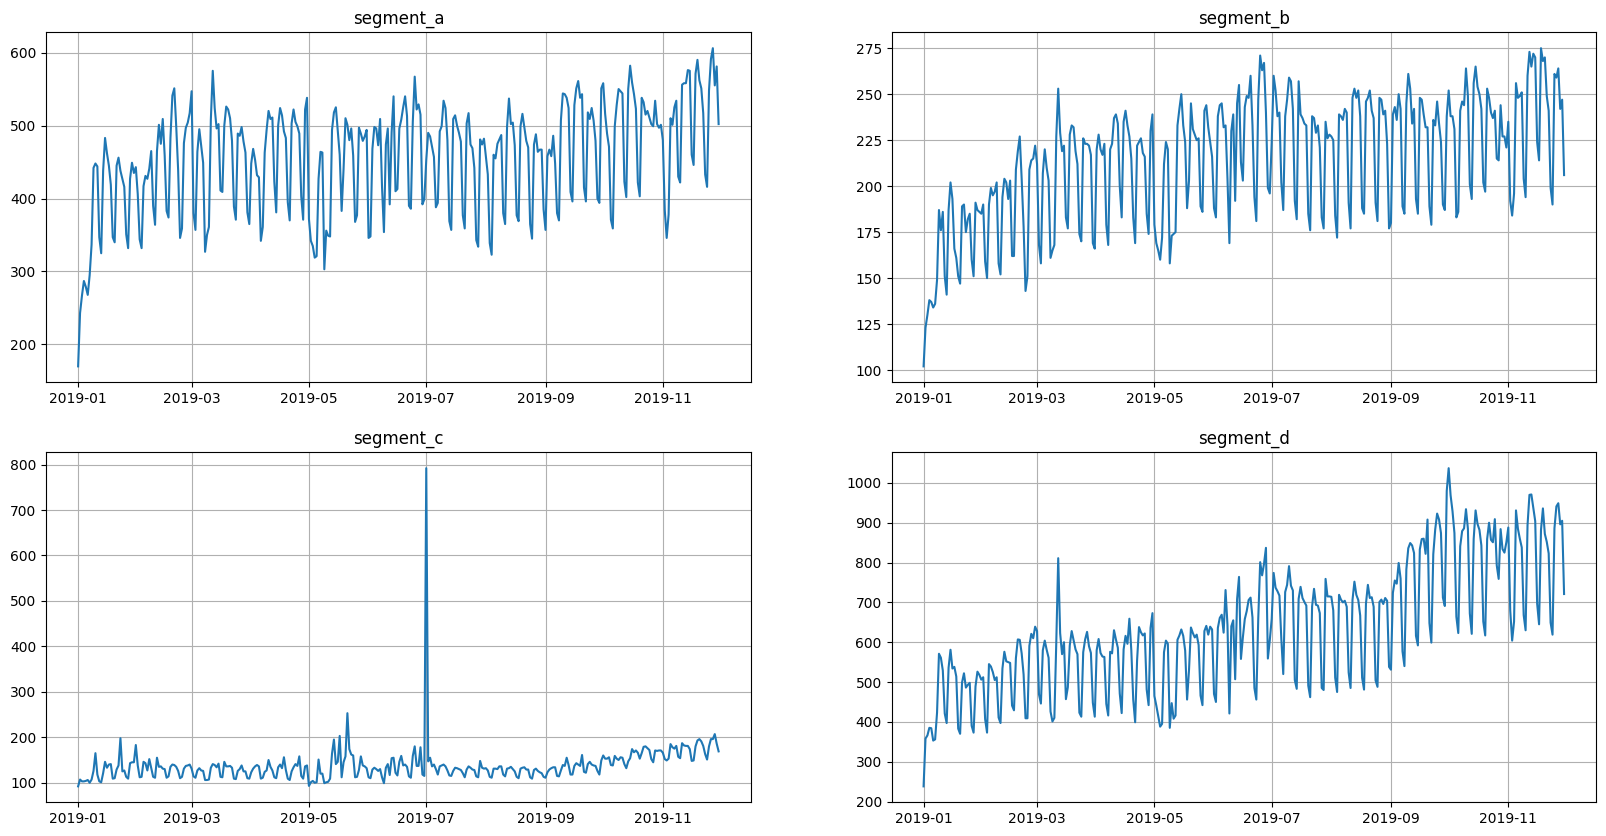

In [ ]:
HORIZON = 14
HISTORY_LEN = 5 * HORIZON
NUMBER_OF_LAGS = 21

df = toy_synthetic.copy(deep=True)
df = TSDataset.to_dataset(df)
ts = TSDataset(df, freq="D")
ts.plot()

### 7.1. Recursive strategy

Рекурсивная стратегия реализована при помощи класса `AutoregressivePipeline`.

#### 7.1.1. AutoRegressivePipeline

`AutoRegressivePipeline` это пайплайн, который итеративно строит предсказание на `step` шагов вперед, после чего использует предсказанные значения как признаки для следующих шагов.

Плюсы:
* Позволяет использовать лаги меньше значения параметра `HORIZON`
* Демонстрирует стабильность в случае рядов с высоким соотношением сигнал/шум

Минусы:
* Может работать медленно в случае малых значений `step`, поскольку требует пересчета признаков  $\lceil{\frac{horizon}{step}} \rceil$ раз
* Может быть неточным на больших горизонтах из-за потенциального накопления ошибки

In [ ]:
model = CatBoostPerSegmentModel()

transforms = [
    LinearTrendTransform(in_column="target"),
    LagTransform(
        in_column="target",
        lags=[i for i in range(1, 1 + NUMBER_OF_LAGS)],
        out_column="target_lag",
    ),
]

autoregressivepipeline = AutoRegressivePipeline(model=model, transforms=transforms, horizon=HORIZON, step=1)

metrics_recursive_df, forecast_recursive_df, _ = autoregressivepipeline.backtest(
    ts=ts, metrics=[SMAPE(), MAE(), MAPE()]
)

autoregressive_pipeline_metrics = metrics_recursive_df.mean()

[Parallel(n_jobs=1)]: Done   1 tasks      | elapsed:    6.6s
[Parallel(n_jobs=1)]: Done   2 tasks      | elapsed:   14.2s
[Parallel(n_jobs=1)]: Done   3 tasks      | elapsed:   21.1s
[Parallel(n_jobs=1)]: Done   4 tasks      | elapsed:   28.2s
[Parallel(n_jobs=1)]: Done   5 tasks      | elapsed:   35.6s
[Parallel(n_jobs=1)]: Done   5 tasks      | elapsed:   35.6s
[Parallel(n_jobs=1)]: Done   1 tasks      | elapsed:    2.1s
[Parallel(n_jobs=1)]: Done   2 tasks      | elapsed:    4.4s
[Parallel(n_jobs=1)]: Done   3 tasks      | elapsed:    6.6s
[Parallel(n_jobs=1)]: Done   4 tasks      | elapsed:    8.7s
[Parallel(n_jobs=1)]: Done   5 tasks      | elapsed:   10.7s
[Parallel(n_jobs=1)]: Done   5 tasks      | elapsed:   10.7s
[Parallel(n_jobs=1)]: Done   1 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done   2 tasks      | elapsed:    0.1s
[Parallel(n_jobs=1)]: Done   3 tasks      | elapsed:    0.1s
[Parallel(n_jobs=1)]: Done   4 tasks      | elapsed:    0.2s
[Parallel(n_jobs=1)]: Do

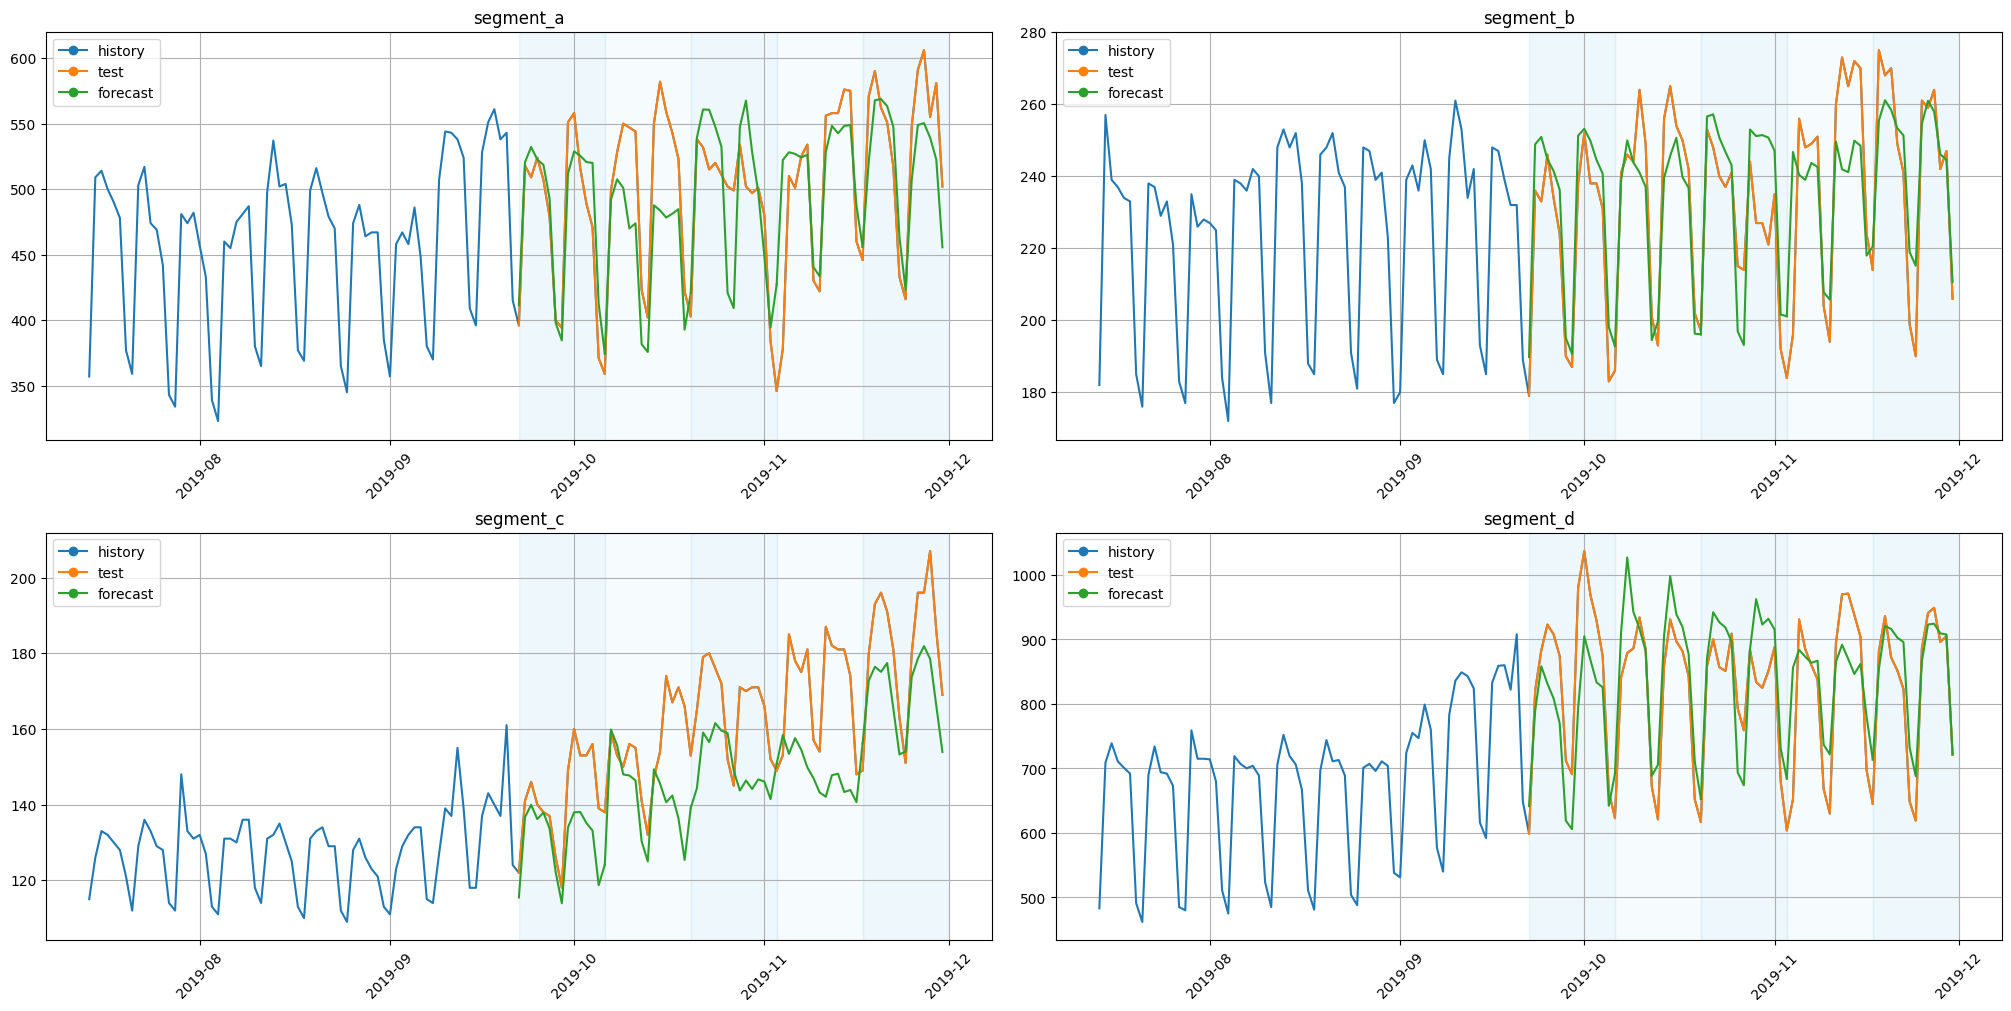

In [ ]:
plot_backtest(forecast_recursive_df, ts, history_len=HISTORY_LEN)

### 7.2. Direct Strategy

Прямая стратегия в ETNA реализована при помощи классов `Pipeline` и `DirectEnsemble`. Стратегия подразумевает условную независимость прогнозов.

#### 7.2.1. Pipeline

`Pipeline` реализует версию прямой стратегии, при которой всего одна модель обучается предсказывать все будущие значения. Это подразумевают следующее:

Плюсы:
* Самый быстрый метод - как на обучении, так и на инференсе

Минусы:

* `Pipeline` не позволяет использовать лаги со значениями меньше параметра `horizon`
* При использовании лагов может начать терять в качестве при увеличении горизонта, так как вслед за этим возрастает ограничение снизу на длину лагов

*NB:*
Как сказано выше, мы не можем использовать лаги со значением меньше параметра `horizon`, поэтому будем использовать лаги со значениями в интервале [`horizon`, `horizon + number_of_lags`]

In [ ]:
model = CatBoostPerSegmentModel()
transforms = [
    LinearTrendTransform(in_column="target"),
    LagTransform(
        in_column="target",
        lags=list(range(HORIZON, HORIZON + NUMBER_OF_LAGS)),
        out_column="target_lag",
    ),
]

pipeline = Pipeline(model=model, transforms=transforms, horizon=HORIZON)

metrics_pipeline_df, forecast_pipeline_df, _ = pipeline.backtest(ts=ts, metrics=[SMAPE(), MAE(), MAPE()])

pipeline_metrics = metrics_pipeline_df.mean()

[Parallel(n_jobs=1)]: Done   1 tasks      | elapsed:    5.8s
[Parallel(n_jobs=1)]: Done   2 tasks      | elapsed:   12.3s
[Parallel(n_jobs=1)]: Done   3 tasks      | elapsed:   19.0s
[Parallel(n_jobs=1)]: Done   4 tasks      | elapsed:   25.8s
[Parallel(n_jobs=1)]: Done   5 tasks      | elapsed:   34.2s
[Parallel(n_jobs=1)]: Done   5 tasks      | elapsed:   34.2s
[Parallel(n_jobs=1)]: Done   1 tasks      | elapsed:    0.2s
[Parallel(n_jobs=1)]: Done   2 tasks      | elapsed:    0.4s
[Parallel(n_jobs=1)]: Done   3 tasks      | elapsed:    0.6s
[Parallel(n_jobs=1)]: Done   4 tasks      | elapsed:    0.8s
[Parallel(n_jobs=1)]: Done   5 tasks      | elapsed:    1.0s
[Parallel(n_jobs=1)]: Done   5 tasks      | elapsed:    1.0s
[Parallel(n_jobs=1)]: Done   1 tasks      | elapsed:    0.1s
[Parallel(n_jobs=1)]: Done   2 tasks      | elapsed:    0.1s
[Parallel(n_jobs=1)]: Done   3 tasks      | elapsed:    0.2s
[Parallel(n_jobs=1)]: Done   4 tasks      | elapsed:    0.2s
[Parallel(n_jobs=1)]: Do

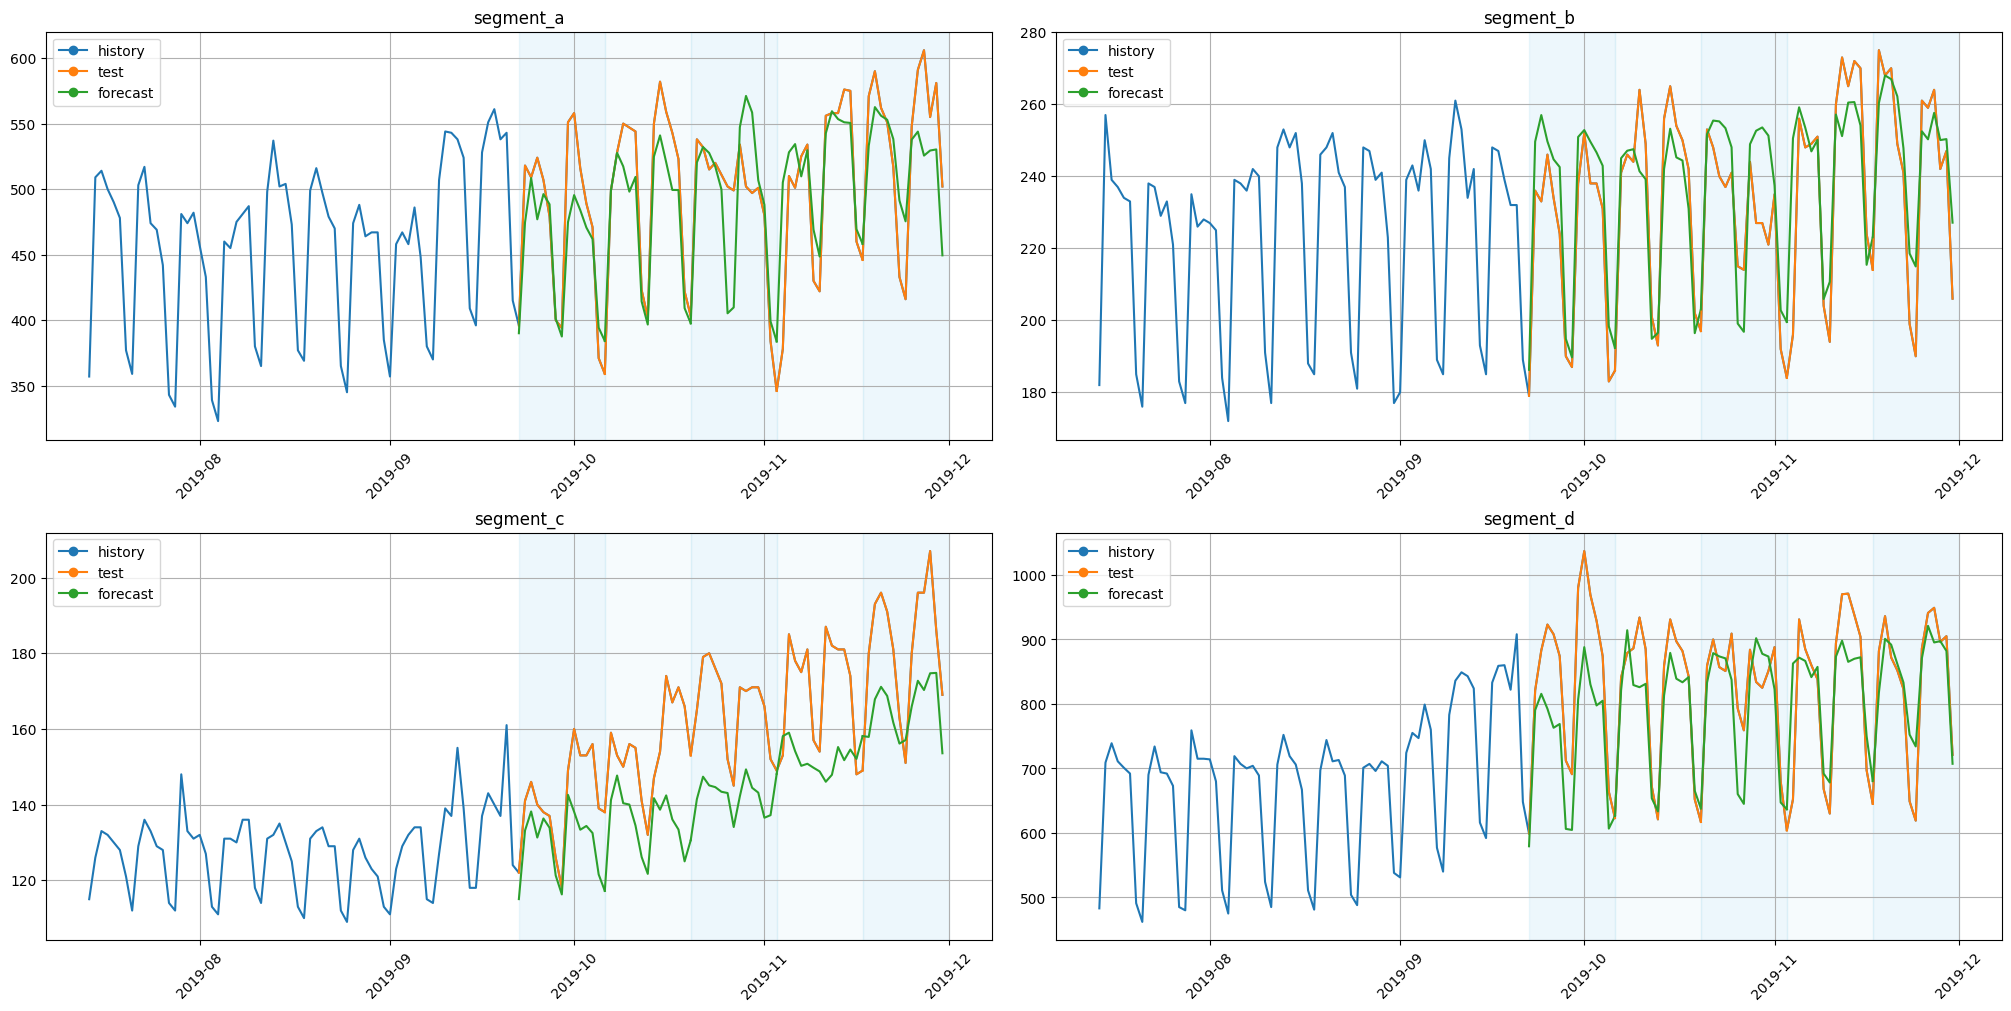

In [ ]:
plot_backtest(forecast_pipeline_df, ts, history_len=HISTORY_LEN)

#### 7.2.2. DirectEnsemble

`DirectEnsemble` обучает отдельный пайплайн для каждого подсегмента. При построении предсказания, метод выбирает в качестве базового пайплайн с наиболее коротким горизонтом, который при этом покрывает текущую предсказываемую точку. Более наглядно процесс представлен на иллюстрации

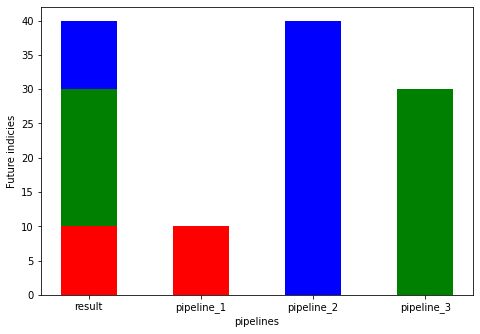

Плюсы:
* Метод может быть крайне полезен когда мы располагаем несколькими разными пайплайнами, каждый из которых эффективен на своем горизонте

Минусы:
* Скорость вычисления падает по мере увеличения количества базовых пайплайнов.
* Прогноз при использовании данной стратегии может выглядеть как ломаная кривая / кривая с разрывами, поскольку составные части прогноза получены из независимых моделей

#### Пример
В качестве примера, зададим отдельный пайплайн для каждой интересующей нас недели. Первую неделю будем предсказывать с использованием лагов в интервале [`7`, `7 + number_of_lags`], вторую - с использованием лагов в интервале [`horizon`, `horizon + number_of_lags`]. Мы, таким образом, ожидаем, что использование более близких лагов для первой недели улучшит качество предсказания.

Начнем со спецификации пайплайнов:

In [ ]:
horizons = [7, 14]

model_1 = CatBoostPerSegmentModel()
transforms_1 = [
    LinearTrendTransform(in_column="target"),
    LagTransform(
        in_column="target",
        lags=[i for i in range(horizons[0], horizons[0] + NUMBER_OF_LAGS)],
        out_column="target_lag",
    ),
]
pipeline_1 = Pipeline(model=model_1, transforms=transforms_1, horizon=horizons[0])


model_2 = CatBoostPerSegmentModel()
transforms_2 = [
    LinearTrendTransform(in_column="target"),
    LagTransform(
        in_column="target",
        lags=[i for i in range(horizons[1], horizons[1] + NUMBER_OF_LAGS)],
        out_column="target_lag",
    ),
]

pipeline_2 = Pipeline(model=model_2, transforms=transforms_2, horizon=horizons[1])

Следующим шагом объединим их в ансамбль и сделаем прогноз:

In [ ]:
ensemble = DirectEnsemble(pipelines=[pipeline_1, pipeline_2])

metrics_ensemble_df, forecast_ensemble_df, _ = ensemble.backtest(ts=ts, metrics=[SMAPE(), MAE(), MAPE()])

ensemble_metrics = metrics_ensemble_df.mean()

[Parallel(n_jobs=1)]: Done   1 tasks      | elapsed:    8.1s
[Parallel(n_jobs=1)]: Done   2 tasks      | elapsed:   14.8s
[Parallel(n_jobs=1)]: Done   2 tasks      | elapsed:   14.8s
[Parallel(n_jobs=1)]: Done   1 tasks      | elapsed:   14.8s
[Parallel(n_jobs=1)]: Done   1 tasks      | elapsed:    7.5s
[Parallel(n_jobs=1)]: Done   2 tasks      | elapsed:   15.1s
[Parallel(n_jobs=1)]: Done   2 tasks      | elapsed:   15.1s
[Parallel(n_jobs=1)]: Done   2 tasks      | elapsed:   29.9s
[Parallel(n_jobs=1)]: Done   1 tasks      | elapsed:    8.0s
[Parallel(n_jobs=1)]: Done   2 tasks      | elapsed:   16.5s
[Parallel(n_jobs=1)]: Done   2 tasks      | elapsed:   16.5s
[Parallel(n_jobs=1)]: Done   3 tasks      | elapsed:   46.5s
[Parallel(n_jobs=1)]: Done   1 tasks      | elapsed:    8.2s
[Parallel(n_jobs=1)]: Done   2 tasks      | elapsed:   18.8s
[Parallel(n_jobs=1)]: Done   2 tasks      | elapsed:   18.8s
[Parallel(n_jobs=1)]: Done   4 tasks      | elapsed:  1.1min
[Parallel(n_jobs=1)]: Do

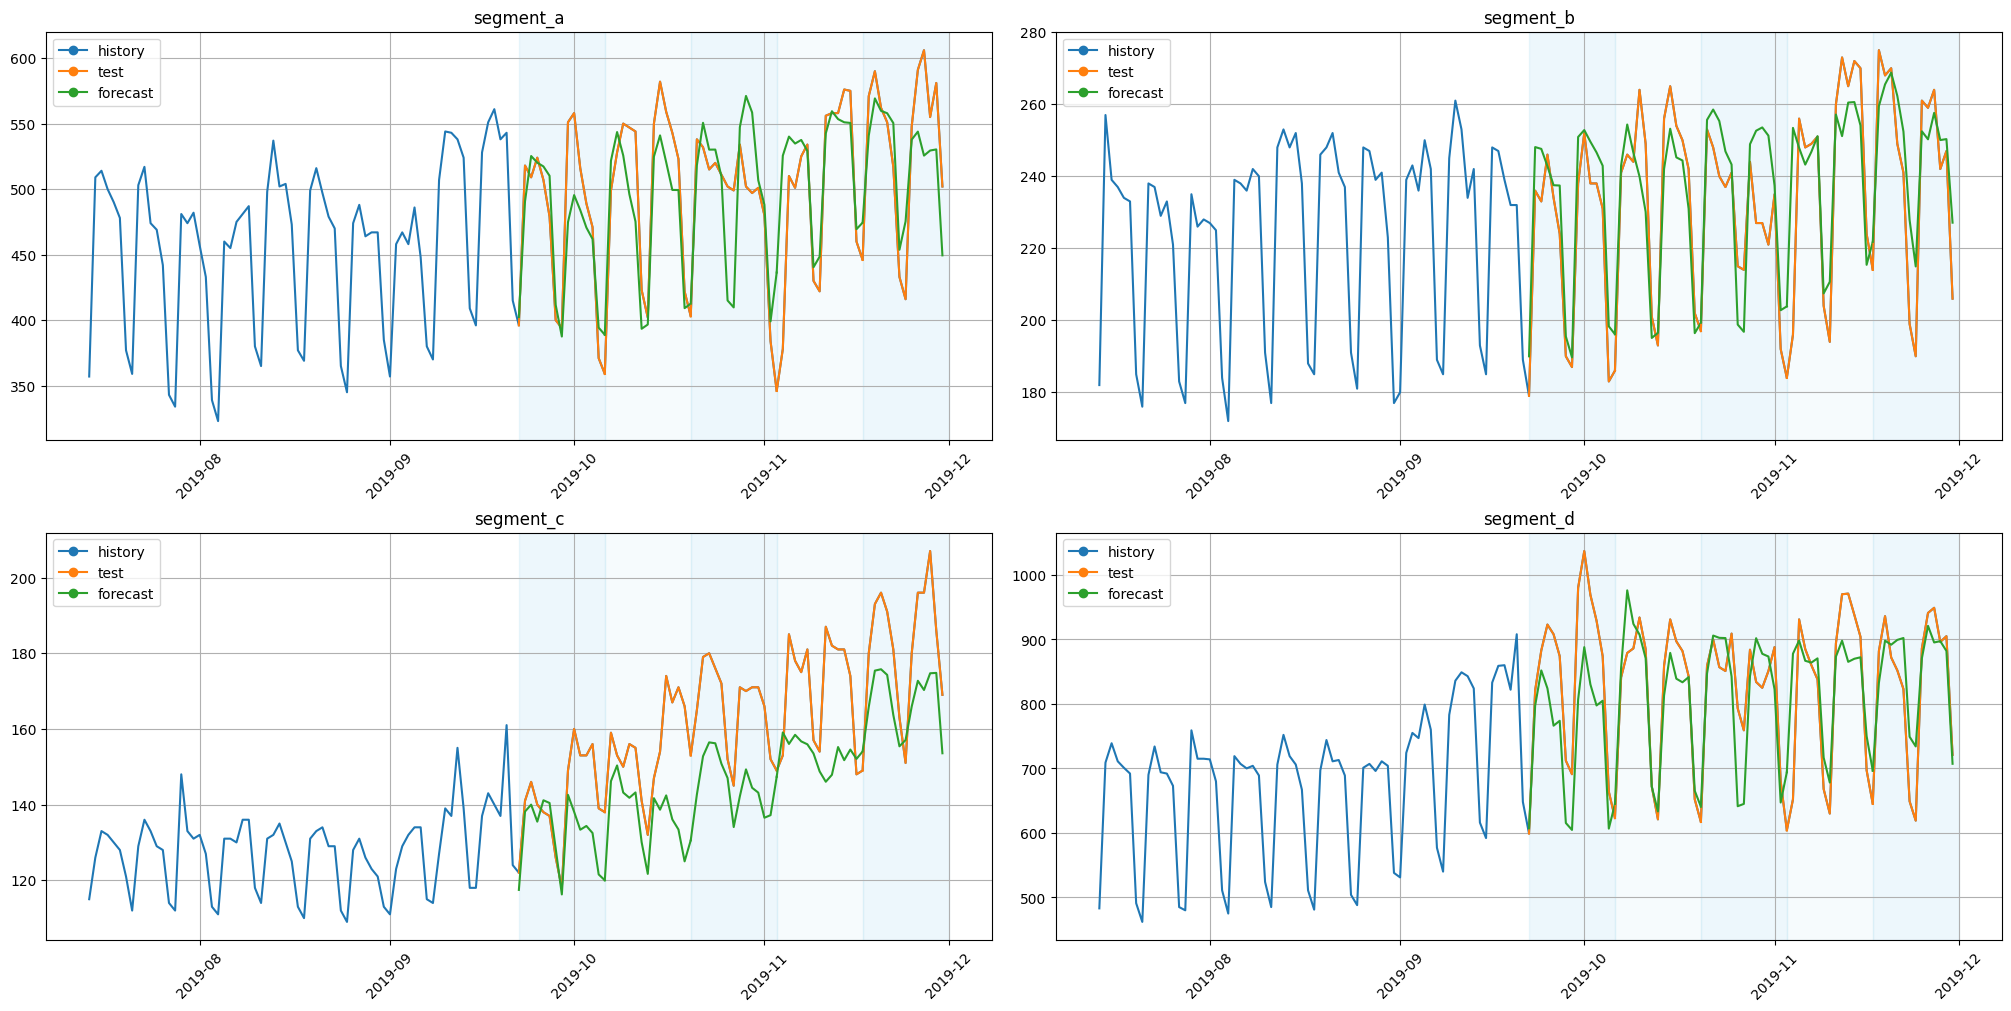

In [ ]:
plot_backtest(forecast_ensemble_df, ts, history_len=HISTORY_LEN)

#### 7.2.3. assemble_pipelines с DirectEnsemble

Поскольку задание `DirectEnsemble` может подразумевать создание множества схожих пайплайнов (отличающихся лишь немногоми аспектами), для повышения эффективности процесса можно использовать `assemble_pipelines`. В этом случае генерация пайплайнов происходит следующим образом:

1. Модели (горизонты) могут задаваться как одна модель (горизонт), или же как последовательность моделей (горизонтов) Мэппинг `i`-го пайплайна к `i`-й модели(горизонту) произойдет автоматически.
2. Преобразования (transforms) могут задаватся как последовательность преобразований или последовательность последовательностей преобразований. Взгляанем на несколько примеров вариантов того, что может происходить с преобразованиями:

Предположим `A`, `B`, `C`, `D`, `E` различные преобразования (transforms).

##### Пример 1

Если последовательность преобразований задается как `[A, B, C]`,  `[A, B, C]` будут применены к каждому пайплайну

##### Пример 2

Если последовательность преобразований задается как `[A, [B, C], D, E]`,  `[A, B, D, E]` будут применены к первому пайплайну и `[A, C, D, E]` ко второму.

##### Пример 3

Если последовательность преобразований задается как `[A, [B, C], [D, E]]`, `[A, B, D]` будут применены к первому пайплайну и `[A, C, E]` ко второму.

##### Пример 4

Если последоваельность преобразований задается как `[A, [B, None]]`, `[A, B]` будут применены к первому пайплайну, и `[A]` ко второму.


Давайте перестроим ансамбль из предыдущего раздела при помощи `assemble_pipelines`

In [ ]:
models = [CatBoostPerSegmentModel(), CatBoostPerSegmentModel()]
transforms = [
    LinearTrendTransform(in_column="target"),
    [
        LagTransform(
            in_column="target",
            lags=[i for i in range(horizons[0], horizons[0] + NUMBER_OF_LAGS)],
            out_column="target_lag",
        ),
        LagTransform(
            in_column="target",
            lags=[i for i in range(horizons[1], horizons[1] + NUMBER_OF_LAGS)],
            out_column="target_lag",
        ),
    ],
]

pipelines = assemble_pipelines(models=models, transforms=transforms, horizons=horizons)
pipelines

[Pipeline(model = CatBoostPerSegmentModel(iterations = None, depth = None, learning_rate = None, logging_level = 'Silent', l2_leaf_reg = None, thread_count = None, ), transforms = [LinearTrendTransform(in_column = 'target', poly_degree = 1, ), LagTransform(in_column = 'target', lags = [7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27], out_column = 'target_lag', )], horizon = 7, ),
 Pipeline(model = CatBoostPerSegmentModel(iterations = None, depth = None, learning_rate = None, logging_level = 'Silent', l2_leaf_reg = None, thread_count = None, ), transforms = [LinearTrendTransform(in_column = 'target', poly_degree = 1, ), LagTransform(in_column = 'target', lags = [14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34], out_column = 'target_lag', )], horizon = 14, )]

// Т.е. 1е преобразование одинаковое, 2ые различаются

Генерация пайплайнов, кажется, действительно упростилась. Обернем их в `DirectEnsemble`:

In [ ]:
ensemble = DirectEnsemble(pipelines=pipelines)

metrics_ensemble_df_2, forecast_ensemble_df_2, _ = ensemble.backtest(ts=ts, metrics=[SMAPE(), MAE(), MAPE()])

[Parallel(n_jobs=1)]: Done   1 tasks      | elapsed:    7.7s
[Parallel(n_jobs=1)]: Done   2 tasks      | elapsed:   15.7s
[Parallel(n_jobs=1)]: Done   2 tasks      | elapsed:   15.7s
[Parallel(n_jobs=1)]: Done   1 tasks      | elapsed:   15.7s
[Parallel(n_jobs=1)]: Done   1 tasks      | elapsed:    8.6s
[Parallel(n_jobs=1)]: Done   2 tasks      | elapsed:   17.5s
[Parallel(n_jobs=1)]: Done   2 tasks      | elapsed:   17.5s
[Parallel(n_jobs=1)]: Done   2 tasks      | elapsed:   33.2s
[Parallel(n_jobs=1)]: Done   1 tasks      | elapsed:    8.4s
[Parallel(n_jobs=1)]: Done   2 tasks      | elapsed:   16.0s
[Parallel(n_jobs=1)]: Done   2 tasks      | elapsed:   16.0s
[Parallel(n_jobs=1)]: Done   3 tasks      | elapsed:   49.2s
[Parallel(n_jobs=1)]: Done   1 tasks      | elapsed:    8.4s
[Parallel(n_jobs=1)]: Done   2 tasks      | elapsed:   16.0s
[Parallel(n_jobs=1)]: Done   2 tasks      | elapsed:   16.0s
[Parallel(n_jobs=1)]: Done   4 tasks      | elapsed:  1.1min
[Parallel(n_jobs=1)]: Do

Проверка того, что прогноз (ожидаемо) не поменялся:

In [ ]:
pd.testing.assert_frame_equal(metrics_ensemble_df_2, metrics_ensemble_df)

### 7.3. Результаты

В этой секции мы обсудили стратегии построения прогноза в ETNA, с примерами. В завершение, сравним качество стратегий, которые мы обсудили, на искомом датасете:

In [ ]:
df_res = pd.DataFrame(
    data=[ensemble_metrics, pipeline_metrics, autoregressive_pipeline_metrics],
    index=["direct_ensemble", "pipeline", "autoregressive_pipeline"],
).drop("fold_number", axis=1)

df_res = df_res.sort_values(by="SMAPE")
df_res

SMAPE        MAE      MAPE
direct_ensemble          7.152913  28.657613  7.004382
autoregressive_pipeline  7.247425  29.945816  7.117746
pipeline                 7.319264  28.476013  7.102676